In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from simulation import Simulation
import os
os.environ["DDE_BACKEND"] = "pytorch" # Export Enviromental variable to use PyTorch
import deepxde as dde
from deepxde.backend import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


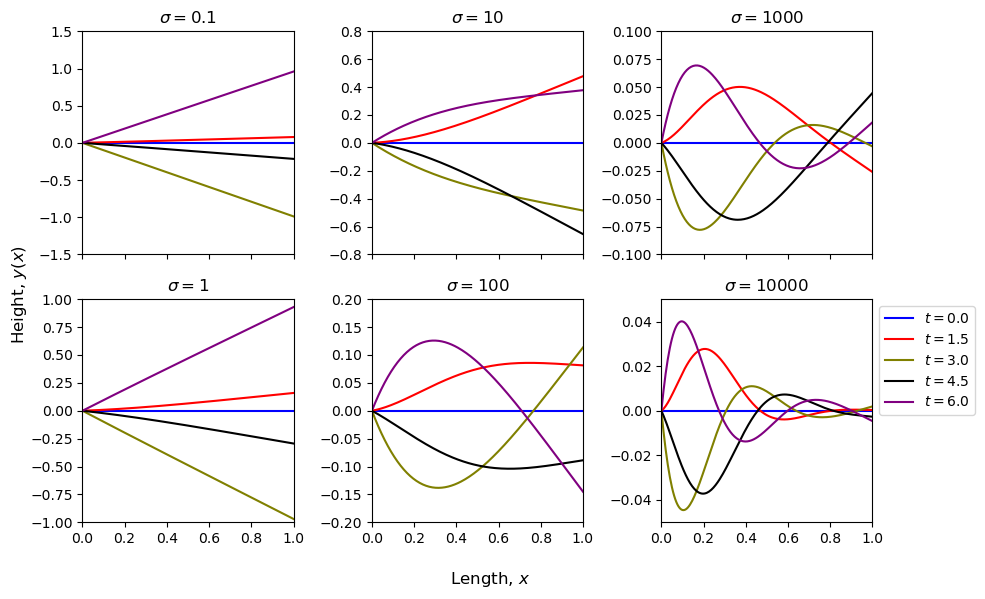

In [2]:
f, ax = plt.subplots(2, 3, sharex=True, figsize=(10, 6))
df01 = pd.read_parquet('./data/s0.1.parquet')
df1 = pd.read_parquet('./data/s1.0.parquet')
df10 = pd.read_parquet('./data/s10.0.parquet')
df100 = pd.read_parquet('./data/s100.0.parquet')
df1000 = pd.read_parquet('./data/s1000.0.parquet')
df10000 = pd.read_parquet('./data/s10000.0.parquet')
colours = ['blue', 'red', 'olive', 'black', 'purple']
for i in range(5):
    gap = 30000
    time = round(df1['t'][gap*i+1],1)
    ax[0, 0].plot(df01['x'][gap*i:gap*(i)+200], df01['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colours[i])
    ax[1, 0].plot(df1['x'][gap*i:gap*(i)+200], df1['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colours[i])
    ax[0, 1].plot(df10['x'][gap*i:gap*(i)+200], df10['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colours[i])
    ax[1, 1].plot(df100['x'][gap*i:gap*(i)+200], df100['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colours[i])
    ax[0, 2].plot(df1000['x'][gap*i:gap*(i)+200], df1000['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colours[i])
    ax[1, 2].plot(df10000['x'][gap*i:gap*(i)+200], df10000['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colours[i])
    ax[0, 0].set_ylim(-1.5, 1.5)
    ax[1, 0].set_ylim(-1, 1)
    ax[0, 1].set_ylim(-0.8, 0.8)
    ax[1, 1].set_ylim(-0.2, 0.2)
    ax[0, 2].set_ylim(-0.1, 0.1)
    ax[1, 2].set_ylim(-0.05, 0.05)
    ax[0, 0].set_xlim(0, 1)
    ax[1, 0].set_xlim(0, 1)
    ax[0, 1].set_xlim(0, 1)
    ax[1, 1].set_xlim(0, 1)
    ax[0, 2].set_xlim(0, 1)
    ax[1, 2].set_xlim(0, 1)
    ax[0, 0].set_title(r'$\sigma = 0.1$')
    ax[1, 0].set_title(r'$\sigma = 1$')
    ax[0, 1].set_title(r'$\sigma = 10$')
    ax[1, 1].set_title(r'$\sigma = 100$')
    ax[0, 2].set_title(r'$\sigma = 1000$')
    ax[1, 2].set_title(r'$\sigma = 10000$')
plt.legend(loc='lower right')
sns.move_legend(ax[1, 2], "upper left", bbox_to_anchor=(1, 1))
f.supxlabel('Length, $x$')
f.supylabel('Height, $y(x)$')
f.tight_layout()
plt.savefig('./figures/filaments.png', bbox_inches='tight', dpi=200)

In [3]:
def analytical_y(G, l0, L, f, x, t):
    c8 = np.cos(np.pi/8) # 0.92
    s8 = np.sin(np.pi/8) # 0.38
    theta = x*(c8 - 1j*s8)/l0
    phi = L*(c8 - 1j*s8)/l0
    p1 = G*l0*(np.exp(1j*(f*t + np.pi/8)))
    p2 = 1/(2 + 2*np.cosh(phi)*np.cos(phi))
    p3 = np.sin(theta) + np.sinh(theta) + np.sin(phi)*np.cosh(phi-theta) - np.cos(phi)*np.sinh(phi-theta) - np.cosh(phi)*np.sin(phi-theta) + np.sinh(phi)*np.cos(phi-theta)
    return p1*p2*p3

p = 12
ms = [2**x for x in range(4, p)]
time_errors = np.zeros(p-4)
length = 10*(1/4)**(1/4)
for k, m in enumerate(ms):
    sim = Simulation(timesteps=m,
                     n_points=2000,
                     max_time=10, osc_freq=4,
                     length=10*(1/4)**(1/4), eta=1)
    sim.run()
    y, x, t, _ = sim.get_data()
    dom = np.linspace(0, length, 2000)
    y_full = np.interp(dom, x, y[-1])
    analytical = analytical_y(G=1, l0=(1/4)**(1/4), L=10*(1/4)**(1/4), f=4, x=dom, t=t[-1])
    time_errors[k] = np.power(np.real(y_full) - np.real(analytical), 2).sum()
    
p = 12
ns = [2**x for x in range(4-1, p-1)]
space_errors = np.zeros(p-4)
for k, n in enumerate(ns):
    sim = Simulation(timesteps=100000,
                     n_points=n,
                     max_time=10, osc_freq=4,
                     length=10*(1/4)**(1/4), eta=1)
    sim.run()
    y, x, t, _ = sim.get_data()
    dom = np.linspace(0, length, 200000)
    y_full = np.interp(dom, x, y[-1])
    analytical = analytical_y(G=1, l0=(1/4)**(1/4), L=10*(1/4)**(1/4), f=4, x=dom, t=t[-1])
    space_errors[k] = np.power(np.real(y_full) - np.real(analytical), 2).sum()

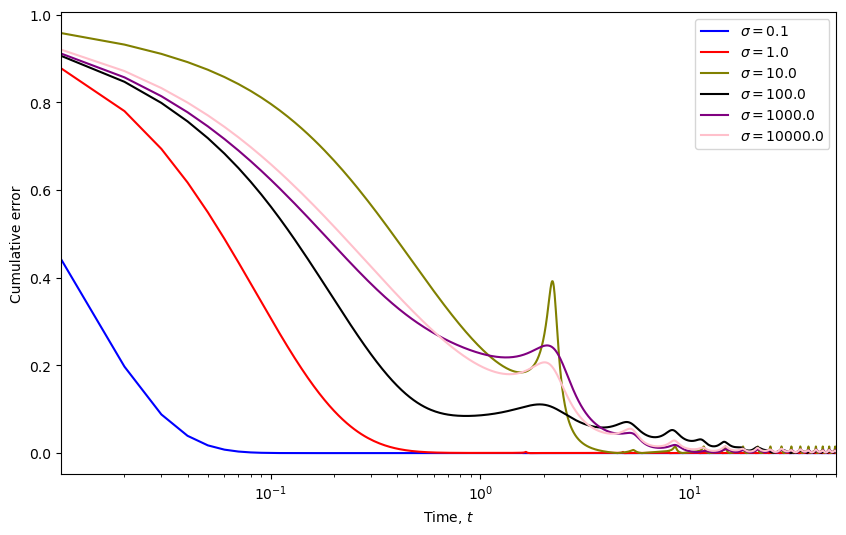

In [4]:
f, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 6))
colours = ['blue', 'red', 'olive', 'black', 'purple', 'pink']
ss = np.array([0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0])
for i, s in enumerate(ss):
    l0 = (1/s)**(1/4)
    x = np.linspace(0, 1, 200)
    t = np.linspace(0, 100, 10000)
    X, T = np.meshgrid(x, t)
    sol = np.real(analytical_y(1, l0, 1, 1, X.ravel(), T.ravel())).reshape(10000, 200)
    df = pd.read_parquet(f'./data/l{s}.parquet')
    sim = df.y.to_numpy().reshape(10000, 200)
    
    rel_e = np.sqrt((np.power(sim-sol, 2)).sum(axis=1))/np.sqrt((np.power(sol, 2)).sum(axis=1))
    ax.plot(t[1:], rel_e[1:], color=colours[i], label=fr'$\sigma = {ss[i]}$')
    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Time, $t$')
    ax.set_ylabel('Cumulative error')
    ax.set_xlim(t[1], 50)
    ax.legend(loc='upper right')
plt.savefig('./figures/error_convergence.png', bbox_inches='tight', dpi=200)

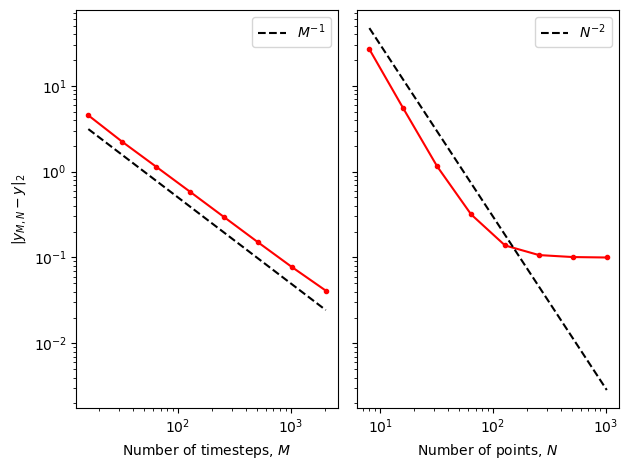

In [5]:
f, ax = plt.subplots(1, 2, sharey=True,)
ax[0].loglog(ms, np.sqrt(time_errors), color='red', marker='.')
ax[0].loglog(ms, 50*1/np.power(ms, 1), linestyle='--', color='black', label='$M^{-1}$')
ax[0].set_xlabel('Number of timesteps, $M$')
ax[0].set_ylabel('$|y_{M,N} - y|_2$')
ax[0].legend()

ax[1].loglog(ns, np.sqrt(space_errors), color='red', marker='.')
ax[1].loglog(ns, 3000*1/np.power(ns, 2), linestyle='--', color='black', label='$N^{-2}$')
ax[1].set_xlabel('Number of points, $N$')
ax[1].legend()
f.tight_layout()
plt.savefig('./figures/all_errors.png', bbox_inches='tight')

In [6]:
def pde(x, y):
    """
    PDE residual definition
    x[:, 0:1] - x-variable
    x[:, 1:2] - t-variable
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return (
        dy_t
        + 0.0001*dy_xxxx
    )

def dy(x, y):
    dy_x = dde.grad.jacobian(y, x, j=0)
    return dy_x

def ddy(x, y):
    return dde.grad.hessian(y, x, i=0, j=0)

def dddy(x, y):
    dy_xx = dde.grad.jacobian(y, x, j=0)
    dy_xxx = dde.grad.hessian(dy_xx, x, j=0)
    return dy_xxx

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

def load_data(dataset_path):
    """
    Reads parquet files and formats data.
    """
    data = pd.read_parquet(dataset_path)
    y_data = data.pop('y').to_numpy().reshape(-1, 1)
    x_data = data.to_numpy()
    return x_data, y_data

def output_transform(x, y):
    return x[:, 0:1]*x[:, 1:2]*y

def feature_transform_sfourier(x):
    x1 = x[:, 0:1]
    t = x[:, 1:2]
    features = torch.cat([x1, t,
                         torch.sin(np.pi*t), torch.cos(np.pi*t),
                         torch.sin(2*np.pi*t), torch.cos(2*np.pi*t),
                         torch.sin(3*np.pi*t), torch.cos(3*np.pi*t),
                         torch.sin(4*np.pi*t), torch.cos(4*np.pi*t),
                         torch.sin(5*np.pi*t), torch.cos(5*np.pi*t),], dim=1)
    return features

B = torch.normal(mean=0, std=1, size=(128, 1), device='cpu')*1
def feature_transform_random(x):
    x1 = x[:, 0:1].reshape(-1, 1)
    t = x[:, 1:2].reshape(-1, 1)
    s = torch.sin((t @ B.T))
    c = torch.cos((t @ B.T))
    features = torch.cat([s, c, x1, t], dim=1)
    return features

geom = dde.geometry.Interval(0, 1) # X 
timedomain = dde.geometry.TimeDomain(0, 10) # T
geomtime = dde.geometry.GeometryXTime(geom, timedomain) # X x T

bc1 = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_l)
bc2 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: dy(x, y) - torch.cos(x[:, 1:2]), boundary_l)
bc3 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: ddy(x, y), boundary_r)
bc4 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: dddy(x, y), boundary_r)

ic = dde.icbc.IC(
    geomtime,
    lambda x: 0,
    lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc1, bc2, bc3, bc4, ic],
    num_domain=6000,
    num_boundary=2000,
    num_initial=2000,
    num_test=10000,
)

net_soft = dde.nn.FNN([2] + [20] * 4 + [1], "tanh", "Glorot uniform")
# net.apply_output_transform(output_transform)
model_soft = dde.Model(data, net_soft)
model_soft.compile('L-BFGS')

Compiling model...
'compile' took 0.000072 s



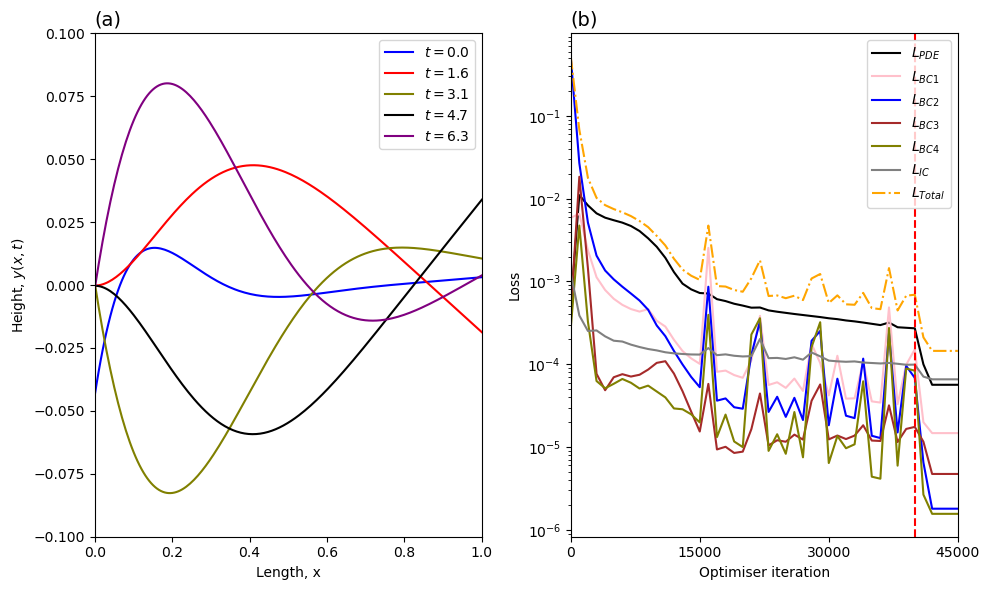

In [7]:
model_soft.restore(save_path = f"./fixed_softbcs_0.001/model-{45000}.pt")
ts = 1000
xs = 200

t_all = np.linspace(0, 10, ts)
x_all = np.linspace(0, 1, xs)
T, X = np.meshgrid(t_all, x_all, indexing='ij')
T_flat = T.ravel()
X_flat = X.ravel()

inputs = np.stack([X_flat, T_flat], axis=-1)
sol_flat = model_soft.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data = pd.DataFrame(sol, columns=x_all, index=t_all)

loss = np.loadtxt(f'./fixed_softbcs_0.001/loss.dat')
loss_df = pd.DataFrame(loss, columns=['step', 'train_pde', 'train_bc1', 'train_bc2', 'train_bc3', 'train_bc4',
                                       'train_ic', 'test_pde','test_bc1', 'test_bc2', 'test_bc3', 'test_bc4', 'test_ic']) # [bc1, bc2, bc3, bc4, ic]
loss_df['train_loss'] = loss_df['train_pde'] + loss_df['train_bc1'] + loss_df['train_bc2'] + loss_df['train_bc3'] + loss_df['train_bc4'] + loss_df['train_ic']
f, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].set_ylabel('Height, $y(x, t)$')
ax[0].set_xlabel('Length, x')
ax[0].set_ylim(-0.1, 0.1)
ax[0].set_xlim(0, 1)
for i in range(5):
    gap = 157
    time = round(t_all[gap*i], 1)
    ax[0].plot(x_all, data.values[gap*i], label=fr'$t = {time}$', color=colours[i])
    ax[0].legend()
ax[0].set_title('(a)', loc='left', fontsize=14,)
ax[1].set_title('(b)', loc='left', fontsize=14,)
ax[1].plot(loss_df['step'], loss_df['train_pde'], label='$L_{PDE}$', color='black')
ax[1].plot(loss_df['step'], loss_df['train_bc1'], label='$L_{BC1}$', color='pink')
ax[1].plot(loss_df['step'], loss_df['train_bc2'], label='$L_{BC2}$', color='blue')
ax[1].plot(loss_df['step'], loss_df['train_bc3'], label='$L_{BC3}$', color='brown')
ax[1].plot(loss_df['step'], loss_df['train_bc4'], label='$L_{BC4}$', color='olive')
ax[1].plot(loss_df['step'], loss_df['train_ic'], label='$L_{IC}$', color='gray')
ax[1].plot(loss_df['step'], loss_df['train_loss'], label='$L_{Total}$', ls='dashdot', color='orange')
ax[1].set_xlabel('Optimiser iteration')
ax[1].set_ylabel('Loss')
ax[1].axvline(40000, ls='dashed', color='red')
ax[1].set_xlim(0, 45000)
ax[1].set_xticks([0, 15000, 30000, 45000])
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
f.tight_layout()
plt.savefig('./figures/pinn_soft_single', bbox_inches='tight', dpi=200)

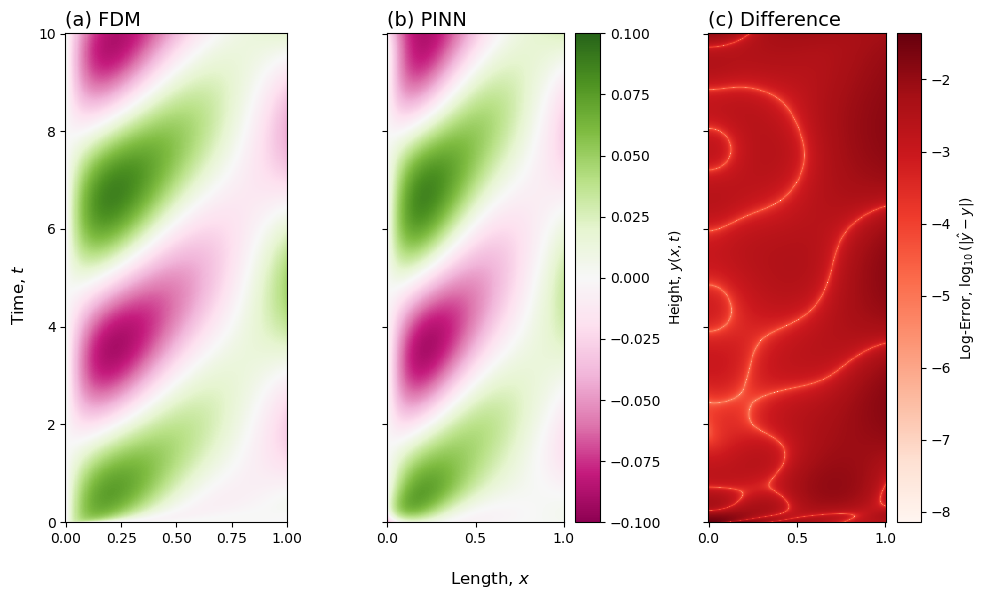

In [8]:
f, ax = plt.subplots(1, 3, figsize=(10, 6), sharey=True)
x, y = load_data(fr'./data/eta_long_{0.001}.parquet')
e_rel = np.abs(data.values - y.reshape(1000, 200))

im = ax[0].pcolormesh(X, T, y.reshape(1000, 200), cmap='PiYG', vmin=-0.1, vmax=0.1)
im = ax[1].pcolormesh(X, T, data.values, cmap='PiYG', vmin=-0.1, vmax=0.1)
f.colorbar(im, label='Height, $y(x, t)$')
x_val = data.columns.values
t_val = data.index.values
X, T = np.meshgrid(x_val, t_val)

im = ax[2].pcolormesh(X, T, np.log10(e_rel), cmap='Reds')
f.colorbar(im, label='Log-Error, $\log_{10}(|\hat{y} - y|)$')
f.supxlabel('Length, $x$')
f.supylabel('Time, $t$')

ax[0].set_title('(a) FDM', loc='left', fontsize=14,)
ax[1].set_title('(b) PINN', loc='left', fontsize=14,)
ax[2].set_title('(c) Difference', loc='left', fontsize=14,)
f.tight_layout()
plt.savefig('./figures/pinn_soft_single_heat_error.png', bbox_inches='tight', dpi=200)

In [9]:
def l2_error_plot_single(model, folders, plot=True):
    iterations = [5000*x for x in range(1, 10)]
    regimes = folders
    etas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    l2_re = np.zeros((len(regimes), len(iterations)))
    for k, regime in enumerate(regimes):
        for j, i in enumerate(iterations):
            model.restore(save_path = f"./{regime}/model-{i}.pt")
            x, y = load_data(fr'./data/eta_long_{etas[k]}.parquet')
            y_pred = model.predict(x[:, [0, 2]])
            l2_re[k, j] = dde.metrics.l2_relative_error(y, y_pred)
    l2re_df = pd.DataFrame(l2_re, index=np.array(etas), columns=iterations)
    if plot:
        sns.heatmap(-np.log10(l2re_df), annot=True, vmin=0, vmax=2, cmap='cividis')
        plt.show()
    return l2re_df

def losses_single(model, folders, soft=False, plot=True):
    iterations = np.array([5000*x for x in range(1, 10)])
    regimes = folders
    etas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    loss_all = np.zeros((len(regimes), len(iterations)))
    for k, regime in enumerate(regimes):
        loss = np.loadtxt(f'./{regime}/loss.dat')
        if soft:
            loss_df = pd.DataFrame(loss, columns=['step', 'train_pde', 'train_bc1', 'train_bc2', 'train_bc3', 'train_bc4',
                                       'train_ic', 'test_pde','test_bc1', 'test_bc2', 'test_bc3', 'test_bc4', 'test_ic']) # [bc1, bc2, bc3, bc4, ic]
            loss_df['train_loss'] = loss_df['train_pde'] + loss_df['train_bc1'] + loss_df['train_bc2'] + loss_df['train_bc3'] + loss_df['train_bc4'] + loss_df['train_ic']
        else:
            loss_df = pd.DataFrame(loss, columns=['step', 'train_pde', 'train_bc2', 'train_bc3', 'train_bc4',
                                       'test_pde', 'test_bc2', 'test_bc3', 'test_bc4']) # [bc1, bc2, bc3, bc4, ic]
            loss_df['train_loss'] = loss_df['train_pde'] + loss_df['train_bc2'] + loss_df['train_bc3'] + loss_df['train_bc4']
        loss_df = loss_df.astype({'step':int})
        loss_all[k] = loss_df.loc[loss_df['step'].isin([5000*x for x in range(1, 10)])].drop_duplicates().train_loss.to_numpy()
            
    loss_all_df = pd.DataFrame(loss_all, index=np.array(etas), columns=iterations)
    if plot:
        sns.heatmap(-np.log10(loss_all_df), annot=True)
        plt.show()
    return loss_all_df


def l2_error_plot_single_period(model, folders, plot=True):
    iterations = [5000*x for x in range(1, 10)]
    regimes = folders
    etas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    l2_re = np.zeros((len(regimes), len(iterations)))
    for k, regime in enumerate(regimes):
        for j, i in enumerate(iterations):
            model.restore(save_path = f"./{regime}/model-{i}.pt")
            x, y = load_data(fr'./data/t15_{etas[k]}.parquet')
            y_pred = model.predict(x[:, [0, 2]])
            l2_re[k, j] = dde.metrics.l2_relative_error(y, y_pred)
    l2re_df = pd.DataFrame(l2_re, index=np.array(etas), columns=iterations)
    if plot:
        sns.heatmap(-np.log10(l2re_df), annot=True, vmin=-2, vmax=0)
        plt.show()
    return l2re_df

In [10]:
soft_l2 = l2_error_plot_single(model_soft, ['single_softbcs',
                                            'fixed_softbcs_0.001',
                                            'fixed_softbcs_0.01', 'fixed_softbcs_0.1', 'fixed_softbcs_1', 'fixed_softbcs_10'], plot=False)

soft_l2_e = l2_error_plot_single_period(model_soft, ['single_softbcs',
                                         'fixed_softbcs_0.001',
                                         'fixed_softbcs_0.01', 'fixed_softbcs_0.1', 'fixed_softbcs_1', 'fixed_softbcs_10'], plot=False)
soft_loss = losses_single(model_soft, ['single_softbcs',
                                         'fixed_softbcs_0.001',
                                         'fixed_softbcs_0.01', 'fixed_softbcs_0.1', 'fixed_softbcs_1', 'fixed_softbcs_10'], soft=True, plot=False)

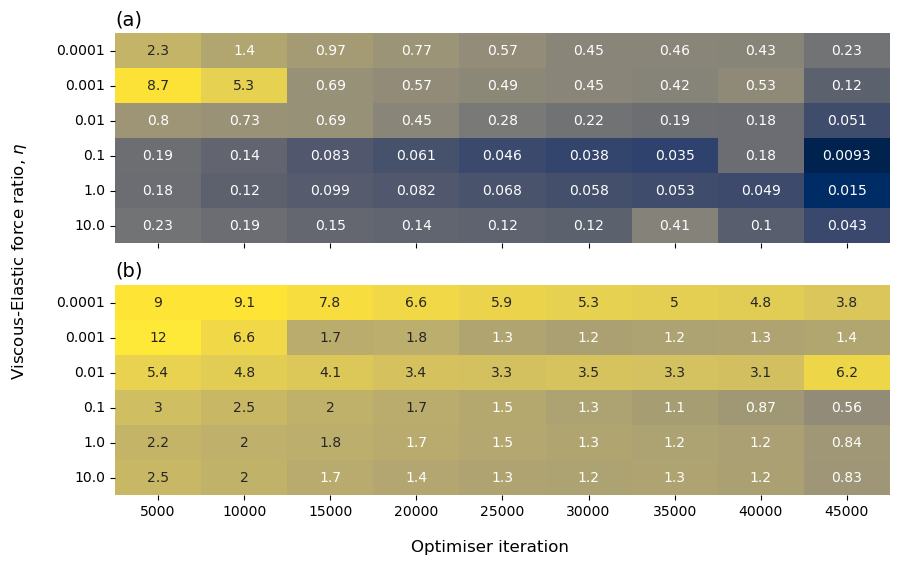

In [11]:
import matplotlib.colors as colors
f, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
sns.heatmap(soft_l2, annot=True, cmap='cividis', norm=colors.LogNorm(vmin=0.01, vmax=10), ax=ax[0], cbar=False)
sns.heatmap(soft_l2_e, annot=True, cmap='cividis', norm=colors.LogNorm(vmin=0.01, vmax=10), ax=ax[1], cbar=False)
f.supxlabel('Optimiser iteration')
f.supylabel('Viscous-Elastic force ratio, $\eta$')
ax[0].set_title('(a)', loc='left', fontsize=14,)
ax[1].set_title('(b)', loc='left', fontsize=14,)
plt.savefig('./figures/l2_errors_soft.png', bbox_inches='tight', dpi=200)

Compiling model...
'compile' took 0.000063 s



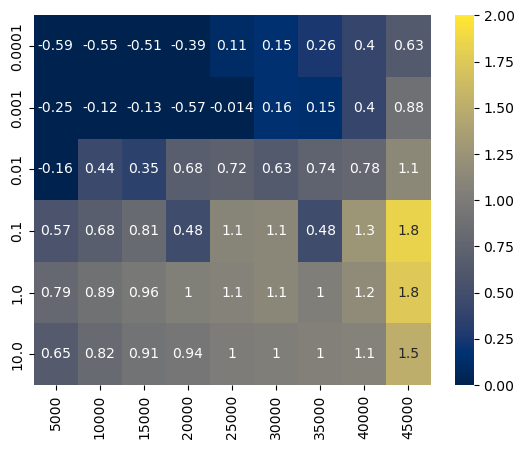

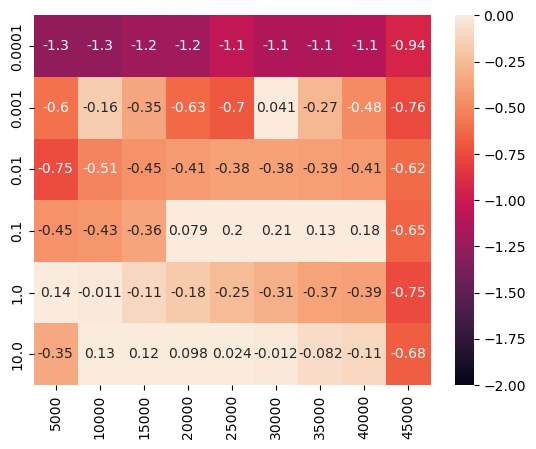

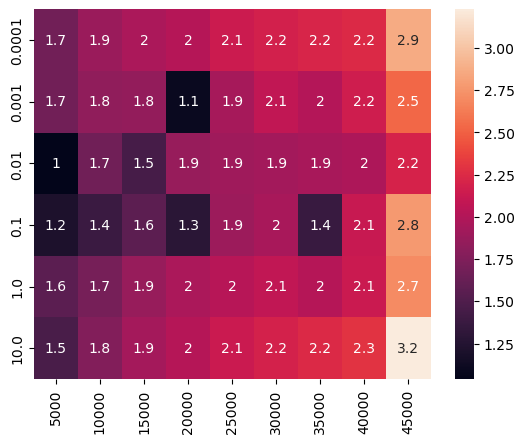

In [12]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc2, bc3, bc4],
    num_domain=6000,
    num_boundary=2000,
    num_initial=2000,
    num_test=10000,
)
net_hard = dde.nn.FNN([2] + [20] * 4 + [1], "tanh", "Glorot uniform")
net_hard.apply_output_transform(output_transform)
model_hard = dde.Model(data, net_hard)
model_hard.compile('L-BFGS')
hard_l2 = l2_error_plot_single(model_hard, ['single_hardbcs', 
                                  'fixed_hardbcs_0.001',
                                  'fixed_hardbcs_0.01', 'fixed_hardbcs_0.1', 'fixed_hardbcs_1', 'fixed_hardbcs_10'])
hard_l2_e = l2_error_plot_single_period(model_hard, ['single_hardbcs', 
                                  'fixed_hardbcs_0.001',
                                  'fixed_hardbcs_0.01', 'fixed_hardbcs_0.1', 'fixed_hardbcs_1', 'fixed_hardbcs_10'])
hard_loss = losses_single(model_hard, ['single_hardbcs', 
                                  'fixed_hardbcs_0.001',
                                  'fixed_hardbcs_0.01', 'fixed_hardbcs_0.1', 'fixed_hardbcs_1', 'fixed_hardbcs_10'])

Compiling model...
'compile' took 0.000077 s



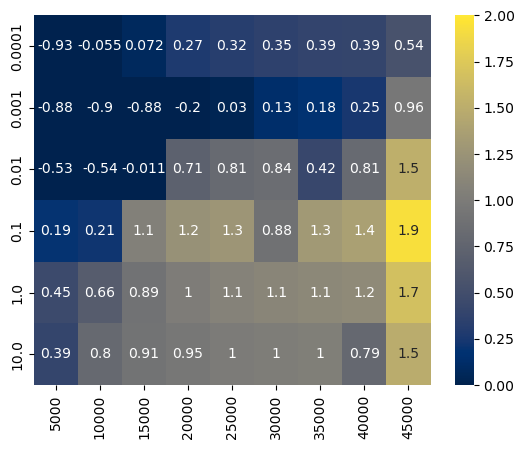

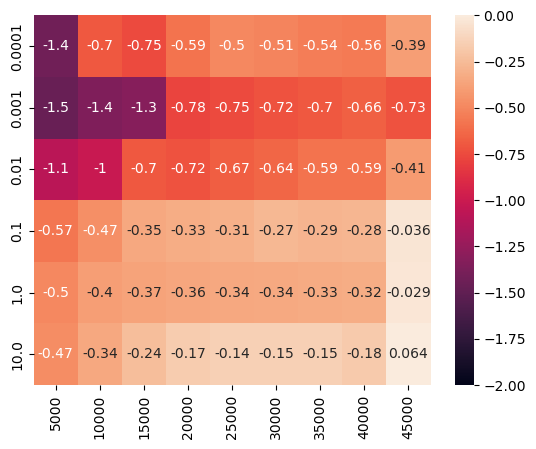

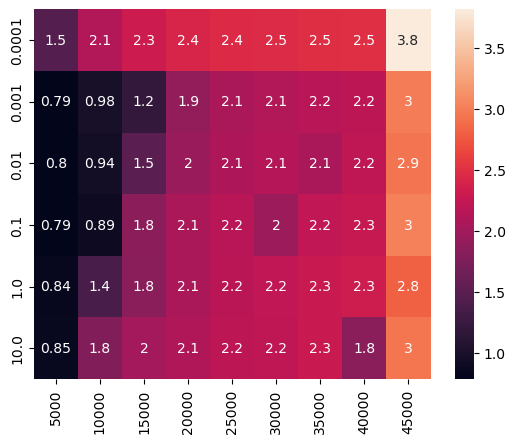

In [13]:
net_sf = dde.nn.FNN([12] + [20] * 4 + [1], "tanh", "Glorot uniform")
net_sf.apply_feature_transform(feature_transform_sfourier)
net_sf.apply_output_transform(output_transform)
model_sf = dde.Model(data, net_sf)
model_sf.compile('L-BFGS')
sf_l2 = l2_error_plot_single(model_sf, ['single_hardbcs_sfourier', 
                                'fixed_hardbcs_sf_0.001', 'fixed_hardbcs_sf_0.01', 'fixed_hardbcs_sf_0.1',
                                'fixed_hardbcs_sf_1', 'fixed_hardbcs_sf_10'])
sf_l2_e = l2_error_plot_single_period(model_sf, ['single_hardbcs_sfourier', 
                                'fixed_hardbcs_sf_0.001', 'fixed_hardbcs_sf_0.01', 'fixed_hardbcs_sf_0.1',
                                'fixed_hardbcs_sf_1', 'fixed_hardbcs_sf_10'])
sf_loss = losses_single(model_sf, ['single_hardbcs_sfourier', 
                                'fixed_hardbcs_sf_0.001', 'fixed_hardbcs_sf_0.01', 'fixed_hardbcs_sf_0.1',
                                'fixed_hardbcs_sf_1', 'fixed_hardbcs_sf_10'])

Compiling model...
'compile' took 0.000074 s



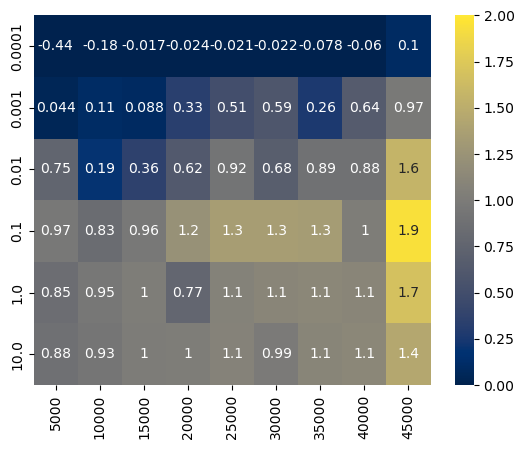

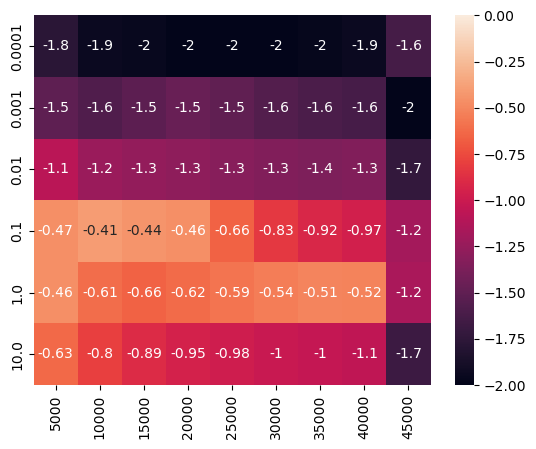

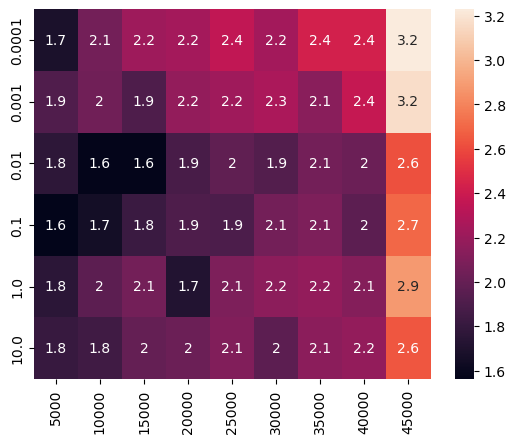

In [14]:
B = torch.tensor(np.load('./single_hardbcs_random_fourier/B_matrix.npy'))
net_rf = dde.nn.FNN([258] + [20] * 4 + [1], "tanh", "Glorot uniform")
net_rf.apply_feature_transform(feature_transform_random)
net_rf.apply_output_transform(output_transform)
model_rf = dde.Model(data, net_rf)
model_rf.compile('L-BFGS')
rf_l2 = l2_error_plot_single(model_rf, ['single_hardbcs_random_fourier', 
                                'fixed_hardbcs_rf_0.001', 'fixed_hardbcs_rf_0.01', 'fixed_hardbcs_rf_0.1',
                                'fixed_hardbcs_rf_1', 'fixed_hardbcs_rf_10'])
rf_l2_e = l2_error_plot_single_period(model_rf, ['single_hardbcs_random_fourier', 
                                'fixed_hardbcs_rf_0.001', 'fixed_hardbcs_rf_0.01', 'fixed_hardbcs_rf_0.1',
                                'fixed_hardbcs_rf_1', 'fixed_hardbcs_rf_10'])
rf_loss = losses_single(model_rf, ['single_hardbcs_random_fourier', 
                                'fixed_hardbcs_rf_0.001', 'fixed_hardbcs_rf_0.01', 'fixed_hardbcs_rf_0.1',
                                'fixed_hardbcs_rf_1', 'fixed_hardbcs_rf_10'])

In [15]:
df1 = rf_loss.reset_index().melt(id_vars=['index'], value_name='loss')
df2 = rf_l2_e.reset_index().melt(id_vars=['index'], value_name='l2_error')
c = pd.merge(df1, df2).astype({'index':str})

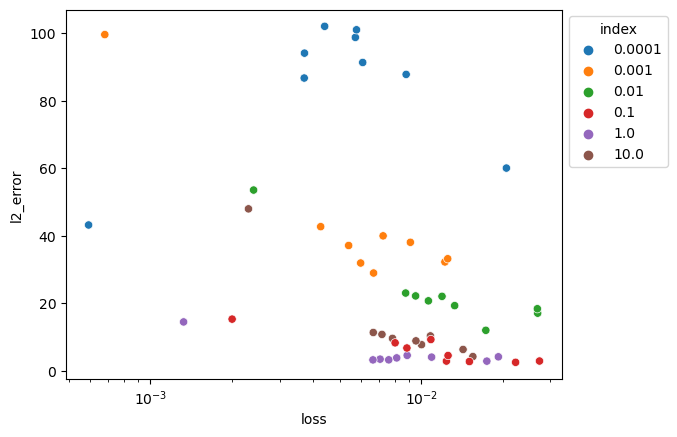

In [16]:
sns.scatterplot(c, x='loss', y='l2_error', hue='index')
ax = plt.gca()
ax.set_xscale('log')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

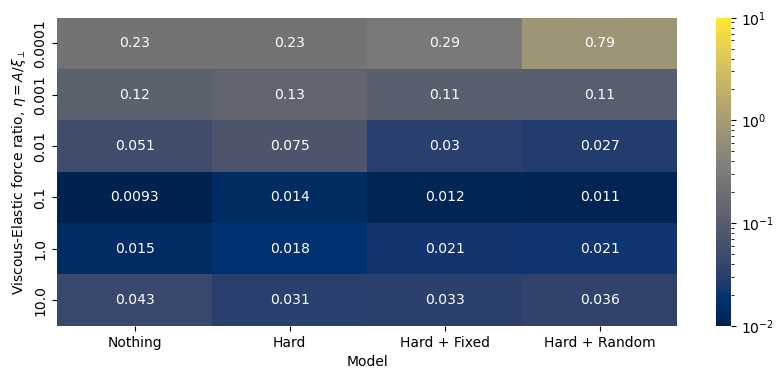

In [17]:
summary = []
summary.append(soft_l2[45000].tolist())
summary.append(hard_l2[45000].tolist())
summary.append(sf_l2[45000].tolist())
summary.append(rf_l2[45000].tolist())
sum_df = pd.DataFrame(np.array(summary).T, columns=['Nothing', 'Hard', 'Hard + Fixed', 'Hard + Random'], index=soft_l2.index)
f, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.heatmap(sum_df, annot=True, cmap='cividis', norm=colors.LogNorm(vmin=0.01, vmax=10), ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel(r'Viscous-Elastic force ratio, $\eta=A/\xi_\perp$')
plt.savefig('./figures/l2_errors_pres.pdf', bbox_inches='tight')

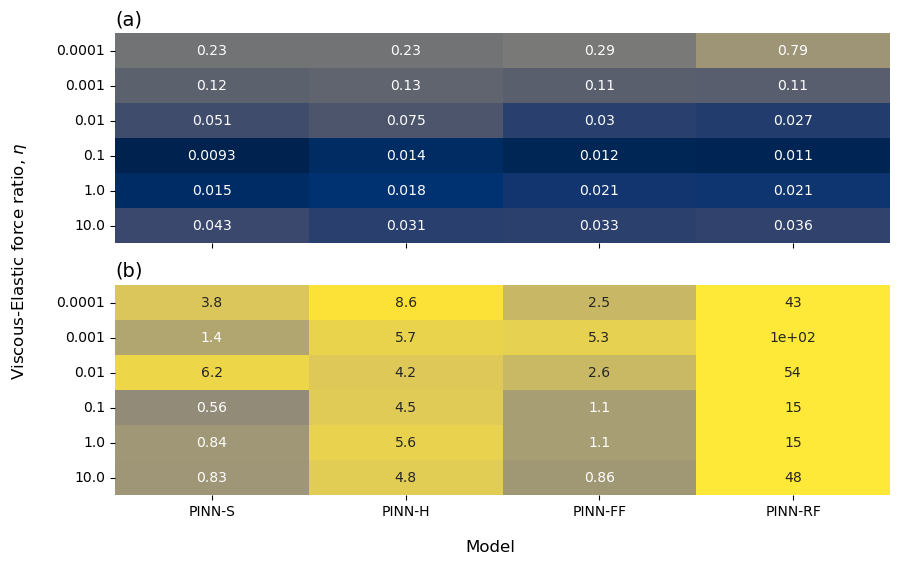

In [18]:
summary = []
summary.append(soft_l2[45000].tolist())
summary.append(hard_l2[45000].tolist())
summary.append(sf_l2[45000].tolist())
summary.append(rf_l2[45000].tolist())
sum_df = pd.DataFrame(np.array(summary).T, columns=['PINN-S', 'PINN-H', 'PINN-FF', 'PINN-RF'], index=soft_l2.index)

summary_e = []
summary_e.append(soft_l2_e[45000].tolist())
summary_e.append(hard_l2_e[45000].tolist())
summary_e.append(sf_l2_e[45000].tolist())
summary_e.append(rf_l2_e[45000].tolist())
sum_df_e = pd.DataFrame(np.array(summary_e).T, columns=['PINN-S', 'PINN-H', 'PINN-FF', 'PINN-RF'], index=soft_l2.index)

f, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
sns.heatmap(sum_df, annot=True, cmap='cividis', norm=colors.LogNorm(vmin=0.01, vmax=10), ax=ax[0], cbar=False)
sns.heatmap(sum_df_e, annot=True, cmap='cividis', norm=colors.LogNorm(vmin=0.01, vmax=10), ax=ax[1], cbar=False)
f.supxlabel('Model')
f.supylabel('Viscous-Elastic force ratio, $\eta$')
ax[0].set_title('(a)', loc='left', fontsize=14,)
ax[1].set_title('(b)', loc='left', fontsize=14,)
plt.savefig('./figures/l2_errors_all.png', bbox_inches='tight', dpi=200)

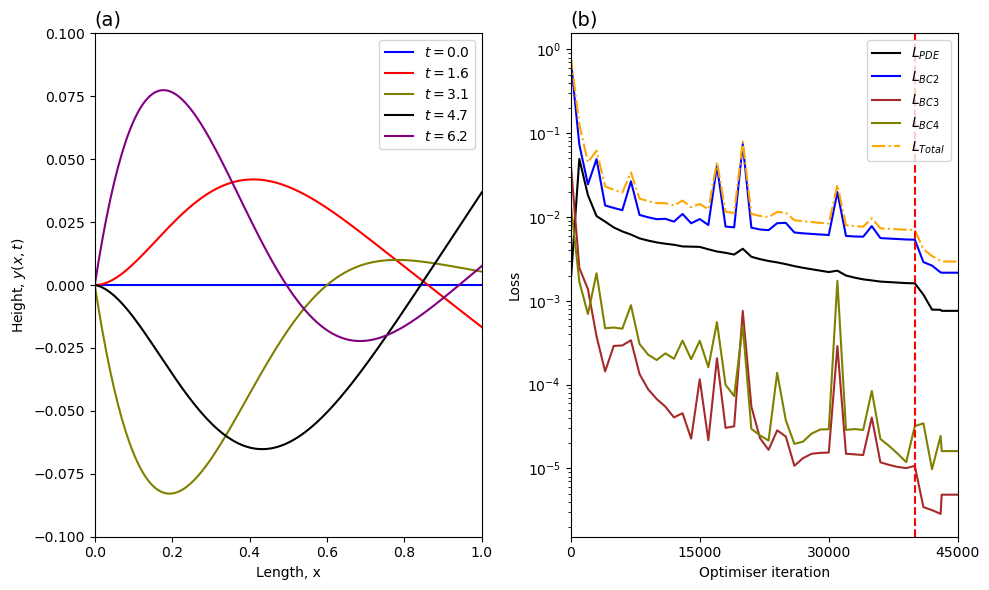

In [19]:
model_hard.restore(save_path = f"./fixed_hardbcs_0.001/model-{45000}.pt")
ts = 1000
xs = 200

t_all = np.linspace(0, 15, ts)
x_all = np.linspace(0, 1, xs)
T, X = np.meshgrid(t_all, x_all, indexing='ij')
T_flat = T.ravel()
X_flat = X.ravel()

inputs = np.stack([X_flat, T_flat], axis=-1)
sol_flat = model_hard.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data = pd.DataFrame(sol, columns=x_all, index=t_all)

loss = np.loadtxt(f'./fixed_hardbcs_0.001/loss.dat')
loss_df = pd.DataFrame(loss, columns=['step', 'train_pde', 'train_bc2', 'train_bc3', 'train_bc4',
                                       'test_pde','test_bc2', 'test_bc3', 'test_bc4']) # [bc1, bc2, bc3, bc4, ic]
loss_df['train_loss'] = loss_df['train_pde'] + loss_df['train_bc2'] + loss_df['train_bc3'] + loss_df['train_bc4']
f, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].set_ylabel('Height, $y(x, t)$')
ax[0].set_xlabel('Length, x')
ax[0].set_ylim(-0.1, 0.1)
ax[0].set_xlim(0, 1)
for i in range(5):
    gap = int(157/1.5)
    time = round(t_all[gap*i], 1)
    ax[0].plot(x_all, data.values[gap*i], label=fr'$t = {time}$', color=colours[i])
    ax[0].legend()
ax[0].set_title('(a)', loc='left', fontsize=14,)
ax[1].set_title('(b)', loc='left', fontsize=14,)
ax[1].plot(loss_df['step'], loss_df['train_pde'], label='$L_{PDE}$', color='black')
ax[1].plot(loss_df['step'], loss_df['train_bc2'], label='$L_{BC2}$', color='blue')
ax[1].plot(loss_df['step'], loss_df['train_bc3'], label='$L_{BC3}$', color='brown')
ax[1].plot(loss_df['step'], loss_df['train_bc4'], label='$L_{BC4}$', color='olive')
ax[1].plot(loss_df['step'], loss_df['train_loss'], label='$L_{Total}$', ls='dashdot', color='orange')
ax[1].set_xlabel('Optimiser iteration')
ax[1].set_ylabel('Loss')
ax[1].axvline(40000, ls='dashed', color='red')
ax[1].set_xlim(0, 45000)
ax[1].set_xticks([0, 15000, 30000, 45000])
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
f.tight_layout()
plt.savefig('./figures/pinn_hard_single', bbox_inches='tight', dpi=200)

/tmp/ipykernel_3604/3277924202.py:12: RuntimeWarning: divide by zero encountered in log10
  im = ax[2].pcolormesh(X, T, np.log10(e_rel), cmap='Reds')


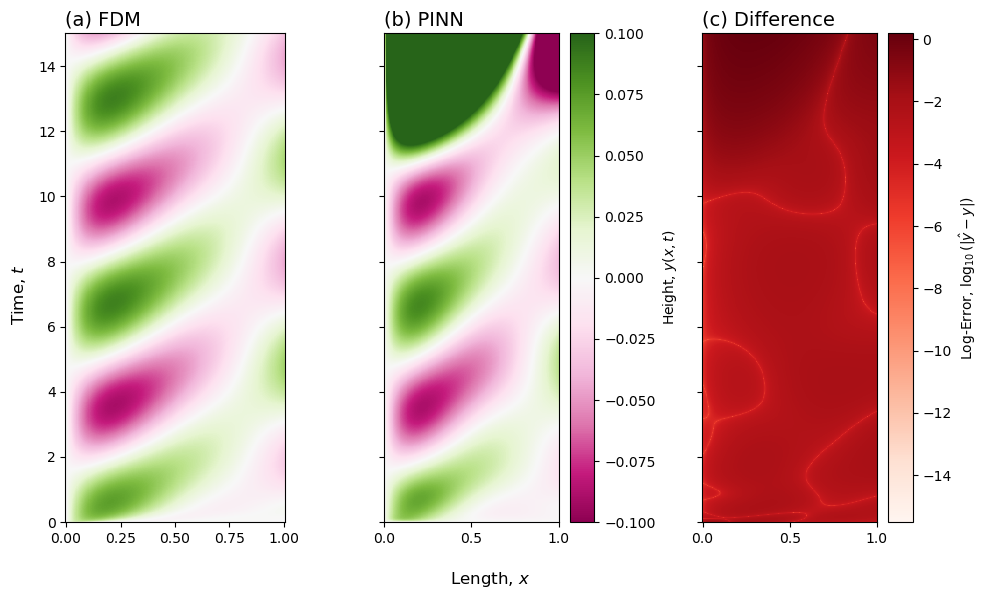

In [20]:
f, ax = plt.subplots(1, 3, figsize=(10, 6), sharey=True)
x, y = load_data(fr'./data/t15_{0.001}.parquet')
e_rel = np.abs(data.values - y.reshape(1000, 200))

im = ax[0].pcolormesh(X, T, y.reshape(1000, 200), cmap='PiYG', vmin=-0.1, vmax=0.1)
im = ax[1].pcolormesh(X, T, data.values, cmap='PiYG', vmin=-0.1, vmax=0.1)
f.colorbar(im, label='Height, $y(x, t)$')
x_val = data.columns.values
t_val = data.index.values
X, T = np.meshgrid(x_val, t_val)

im = ax[2].pcolormesh(X, T, np.log10(e_rel), cmap='Reds')
f.colorbar(im, label='Log-Error, $\log_{10}(|\hat{y} - y|)$')
f.supxlabel('Length, $x$')
f.supylabel('Time, $t$')

ax[0].set_title('(a) FDM', loc='left', fontsize=14,)
ax[1].set_title('(b) PINN', loc='left', fontsize=14,)
ax[2].set_title('(c) Difference', loc='left', fontsize=14,)
f.tight_layout()
plt.savefig('./figures/pinn_hard_single_heat_error.png', bbox_inches='tight', dpi=200)

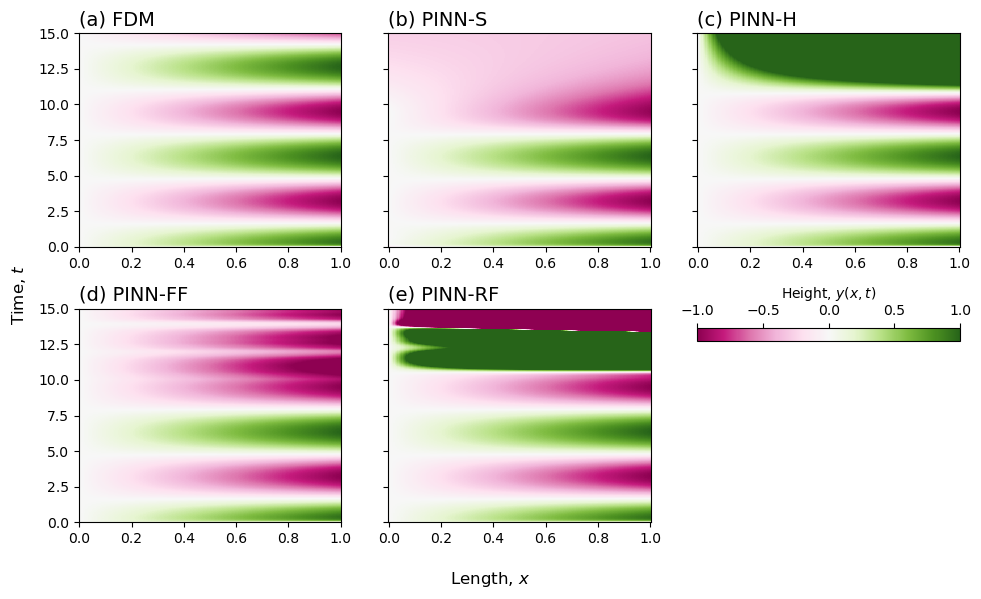

In [21]:
x, y = load_data(fr'./data/t15_{1}.parquet')
model_hard.restore(save_path = f"./fixed_hardbcs_1/model-{45000}.pt")
ts = 1000
xs = 200

t_all = np.linspace(0, 15, ts)
x_all = np.linspace(0, 1, xs)
T, X = np.meshgrid(t_all, x_all, indexing='ij')
T_flat = T.ravel()
X_flat = X.ravel()

inputs = np.stack([X_flat, T_flat], axis=-1)
sol_flat = model_hard.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_hard = pd.DataFrame(sol, columns=x_all, index=t_all)

model_soft.restore(save_path = f"./fixed_softbcs_1/model-{45000}.pt")
sol_flat = model_soft.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_soft = pd.DataFrame(sol, columns=x_all, index=t_all)

model_sf.restore(save_path = f"./fixed_hardbcs_sf_1/model-{45000}.pt")
sol_flat = model_sf.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_sf = pd.DataFrame(sol, columns=x_all, index=t_all)

model_rf.restore(save_path = f"./fixed_hardbcs_rf_1/model-{45000}.pt")
sol_flat = model_rf.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_rf = pd.DataFrame(sol, columns=x_all, index=t_all)


f, ax = plt.subplots(2,3, figsize=(10,6), sharey=True)
ax[1][2].set_visible(False)

#ax[1][0].set_position([0.24,0.125,0.228,0.343])
#ax[1][1].set_position([0.55,0.125,0.228,0.343])
im = ax[0, 0].pcolormesh(X, T, y.reshape(1000, 200), cmap='PiYG', vmin=-1, vmax=1)
ax[0, 0].set_ylim(0, 15)
im = ax[0, 1].pcolormesh(X, T, data_soft.values, cmap='PiYG', vmin=-1, vmax=1)
im = ax[0, 2].pcolormesh(X, T, data_hard.values, cmap='PiYG', vmin=-1, vmax=1)
im = ax[1, 0].pcolormesh(X, T, data_sf.values, cmap='PiYG', vmin=-1, vmax=1)
im = ax[1, 1].pcolormesh(X, T, data_rf.values, cmap='PiYG', vmin=-1, vmax=1)
im = ax[1, 2].pcolormesh(X, T, data_rf.values, cmap='PiYG', vmin=-1, vmax=1)
ax[0, 0].set_title('(a) FDM', loc='left', fontsize=14,)
ax[0, 1].set_title('(b) PINN-S', loc='left', fontsize=14,)
ax[0, 2].set_title('(c) PINN-H', loc='left', fontsize=14)
ax[1, 0].set_title('(d) PINN-FF', loc='left', fontsize=14)
ax[1, 1].set_title('(e) PINN-RF', loc='left', fontsize=14)
f.supxlabel('Length, $x$')
f.supylabel('Time, $t$')
f.colorbar(im, label='Height, $y(x, t)$', orientation='horizontal', location='top')
f.tight_layout()
plt.savefig('./figures/fixed_extropolation.png', bbox_inches='tight', dpi=200)

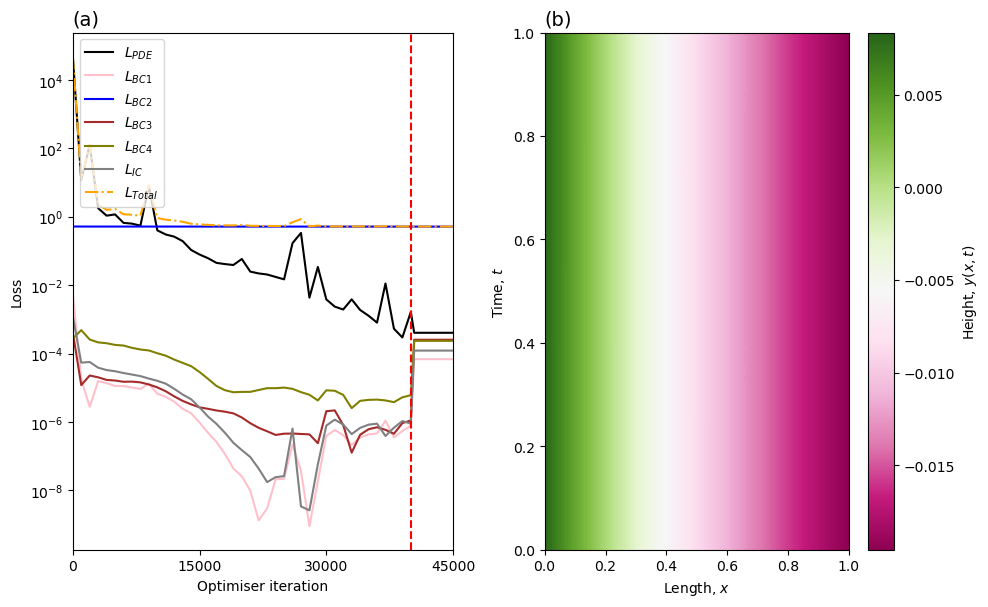

In [22]:
loss = np.loadtxt('./lhs_fixed_softbcs_10000/loss.dat')
loss_df = pd.DataFrame(loss, columns=['step', 'train_pde', 'train_bc1', 'train_bc2', 'train_bc3', 'train_bc4',
                           'train_ic', 'test_pde', 'test_bc1', 'test_bc2', 'test_bc3', 'test_bc4',
                           'test_ic']) # [bc1, bc2, bc3, bc4, ic]
loss_df['train_loss'] = loss_df['train_pde'] +\
loss_df['train_bc1'] + loss_df['train_bc2'] + loss_df['train_bc3'] + loss_df['train_bc4'] + loss_df['train_ic']
model_soft.restore(save_path = "./lhs_fixed_softbcs_10000/model-45000.pt")
ts = 1000
xs = 200

t_all = np.linspace(0, 10, ts)
x_all = np.linspace(0, 1, xs)
T, X = np.meshgrid(t_all, x_all, indexing='ij')
T_flat = T.ravel()
X_flat = X.ravel()

inputs = np.stack([X_flat, T_flat], axis=-1)
sol_flat = model_soft.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data = pd.DataFrame(sol, columns=x_all, index=t_all)

x_val = data.columns.values
t_val = data.index.values
X, T = np.meshgrid(x_val, t_val)

f, ax = plt.subplots(1, 2, figsize=(10, 6))
im = ax[1].pcolormesh(X, T, data.values, cmap='PiYG')
ax[1].set_xlabel('Length, $x$')
ax[1].set_ylabel('Time, $t$')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[0].plot(loss_df['step'], loss_df['train_pde'], label='$L_{PDE}$', color='black')
ax[0].plot(loss_df['step'], loss_df['train_bc1'], label='$L_{BC1}$', color='pink')
ax[0].plot(loss_df['step'], loss_df['train_bc2'], label='$L_{BC2}$', color='blue')
ax[0].plot(loss_df['step'], loss_df['train_bc3'], label='$L_{BC3}$', color='brown')
ax[0].plot(loss_df['step'], loss_df['train_bc4'], label='$L_{BC4}$', color='olive')
ax[0].plot(loss_df['step'], loss_df['train_ic'], label='$L_{IC}$', color='gray')
ax[0].plot(loss_df['step'], loss_df['train_loss'], label='$L_{Total}$', ls='dashdot', color='orange')
ax[0].set_xlabel('Optimiser iteration')
ax[0].set_ylabel('Loss')
ax[0].axvline(40000, ls='dashed', color='red')
ax[0].set_xlim(0, 45000)
ax[0].set_xticks([0, 15000, 30000, 45000])
ax[0].set_yscale('log')
ax[0].legend(loc='upper left')
f.colorbar(im, label='Height, $y(x, t)$')
f.tight_layout()
ax[0].set_title('(a)', loc='left', fontsize=14,)
ax[1].set_title('(b)', loc='left', fontsize=14,)
plt.savefig('./figures/eta_lhs.png', bbox_inches='tight', dpi=200)

In [23]:
def l2_error_plot(model, folder):
    iterations = [5000*x for x in range(1, 10)]
    regimes = ['floppy_32', 'floppy_stiff33', 'stiff_floppy34', 'stiff_35', 'verystiff_36']
    l2_re = np.zeros((len(regimes), len(iterations)))
    for k, regime in enumerate(regimes):
        for j, i in enumerate(iterations):
            model.restore(save_path = f"./{folder}/model-{i}.pt")
            x, y = load_data(fr'./data/{regime}.parquet')
            y_pred = model.predict(x)
            l2_re[k, j] = dde.metrics.l2_relative_error(y, y_pred)

    regimes_clean = ['0.0001-0.001', '0.001-0.01', '0.01-0.1', '0.1-1', '1-10']
    l2re_df = pd.DataFrame(l2_re, index=regimes_clean, columns=iterations)
    return l2re_df

In [24]:
geom = dde.geometry.Rectangle([0, 0.0001], [1, 10]) # X x [\eta]
timedomain = dde.geometry.TimeDomain(0, 10) # T
geomtime = dde.geometry.GeometryXTime(geom, timedomain) # X x [\eta] x T

def pde(x, y):
    """
    PDE residual definition
    x[:, 0:1] - x-variable
    x[:, 1:2] - eta
    x[:, 2:3] - t-variable
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=2)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return (
        dy_t
        + x[:, 1:2]*dy_xxxx
    )

def dy(x, y):
    dy_x = dde.grad.jacobian(y, x, j=0)
    return dy_x

def ddy(x, y):
    return dde.grad.hessian(y, x, i=0, j=0)

def dddy(x, y):
    dy_xx = dde.grad.jacobian(y, x, j=0)
    dy_xxx = dde.grad.hessian(dy_xx, x, j=0)
    return dy_xxx

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

bc1 = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_l)
bc2 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: dy(x, y) - torch.cos(x[:, 2:3]), boundary_l)
bc3 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: ddy(x, y), boundary_r)
bc4 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: dddy(x, y), boundary_r)

ic = dde.icbc.IC(
    geomtime,
    lambda x: 0,
    lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc1, bc2, bc3, bc4, ic],
    num_domain=6000,
    num_boundary=2000,
    num_initial=2000,
    num_test=6000,
)

In [25]:
net_psoft = dde.nn.FNN([3] + [20] * 4 + [1], "tanh", "Glorot uniform")
model_psoft = dde.Model(data, net_psoft)
model_psoft.compile('L-BFGS')

folder = 'run_soft_0'
ps_l2_df = l2_error_plot(model_psoft, folder)

model_psoft.restore('./run_soft_0/model-45000.pt')
t_all = np.linspace(0, 10, ts)
x_all = np.linspace(0, 1, xs)
eta = 1
T, X = np.meshgrid(t_all, x_all, indexing='ij')
T_flat = T.ravel()
X_flat = X.ravel()
ETA_flat = np.full_like(T_flat, eta)
inputs = np.stack([X_flat, ETA_flat, T_flat], axis=-1)

sol_flat = model_psoft.predict(inputs)
sol = sol_flat.reshape(ts, xs)
data_soft = pd.DataFrame(sol, columns=x_all, index=t_all)

Compiling model...
'compile' took 0.000067 s



In [26]:
geom = dde.geometry.Rectangle([0, 0.0001], [1, 10]) # X x [\eta]
timedomain = dde.geometry.TimeDomain(0, 10) # T
geomtime = dde.geometry.GeometryXTime(geom, timedomain) # X x [\eta] x T

def pde(x, y):
    """
    PDE residual definition
    x[:, 0:1] - x-variable
    x[:, 1:2] - eta
    x[:, 2:3] - t-variable
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=2)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return (
        dy_t
        + x[:, 1:2]*dy_xxxx
    )

def dy(x, y):
    dy_x = dde.grad.jacobian(y, x, j=0)
    return dy_x

def ddy(x, y):
    return dde.grad.hessian(y, x, i=0, j=0)

def dddy(x, y):
    dy_xx = dde.grad.jacobian(y, x, j=0)
    dy_xxx = dde.grad.hessian(dy_xx, x, j=0)
    return dy_xxx

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

def output_transform(x, y):
    return x[:, 0:1]*x[:, 2:3]*y

bc1 = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_l)
bc2 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: dy(x, y) - torch.cos(x[:, 2:3]), boundary_l)
bc3 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: ddy(x, y), boundary_r)
bc4 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: dddy(x, y), boundary_r)

ic = dde.icbc.IC(
    geomtime,
    lambda x: 0,
    lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc2, bc3, bc4],
    num_domain=6000,
    num_boundary=2000,
    num_test=6000,
)
net_phard = dde.nn.FNN([3] + [20] * 4 + [1], "tanh", "Glorot uniform")
net_phard.apply_output_transform(output_transform)
model_phard = dde.Model(data, net_phard)
model_phard.compile('L-BFGS')

folder = 'run_hard_0'
ph_l2_df = l2_error_plot(model_phard, folder)

model_phard.restore('./run_hard_0/model-45000.pt')
t_all = np.linspace(0, 10, ts)
x_all = np.linspace(0, 1, xs)
eta = 1
T, X = np.meshgrid(t_all, x_all, indexing='ij')
T_flat = T.ravel()
X_flat = X.ravel()
ETA_flat = np.full_like(T_flat, eta)
inputs = np.stack([X_flat, ETA_flat, T_flat], axis=-1)

sol_flat = model_phard.predict(inputs)
sol = sol_flat.reshape(ts, xs)
data_hard = pd.DataFrame(sol, columns=x_all, index=t_all)

Compiling model...
'compile' took 0.000060 s



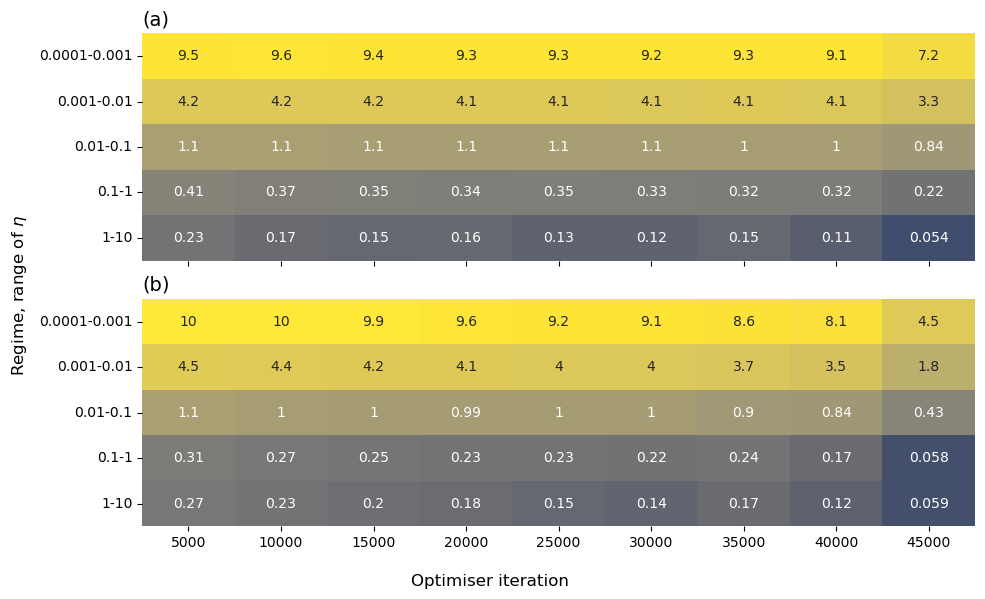

In [27]:
f, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
sns.heatmap(ps_l2_df, annot=True, cmap='cividis', norm=colors.LogNorm(vmin=0.01, vmax=10), ax=ax[0], cbar=False)
sns.heatmap(ph_l2_df, annot=True, cmap='cividis', norm=colors.LogNorm(vmin=0.01, vmax=10), ax=ax[1], cbar=False)
f.supxlabel('Optimiser iteration')
f.supylabel('Regime, range of $\eta$')
ax[0].set_title('(a)', loc='left', fontsize=14,)
ax[1].set_title('(b)', loc='left', fontsize=14,)
f.tight_layout()
plt.savefig('./figures/l2_softhard.png', bbox_inches='tight', dpi=200)

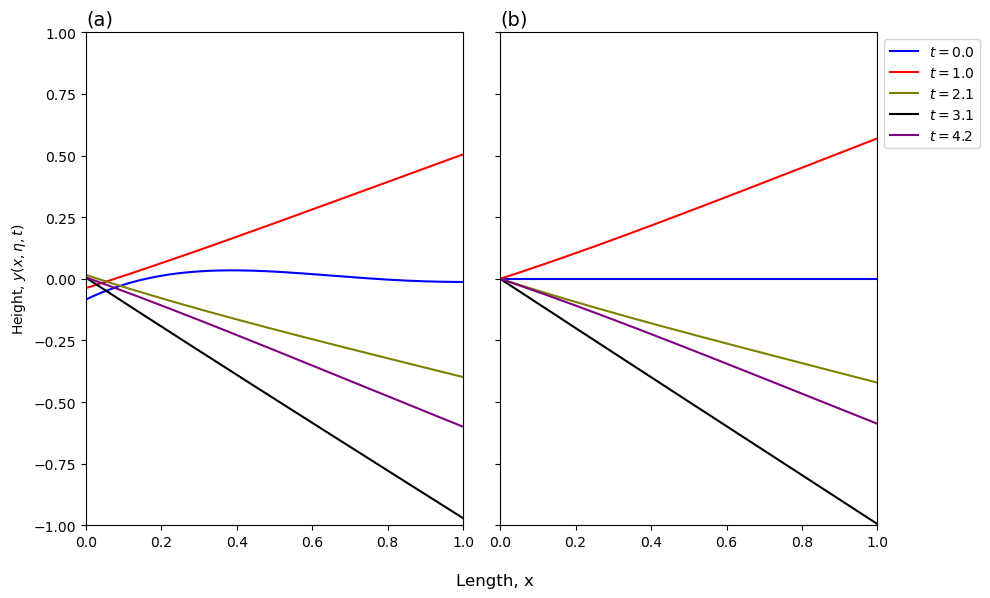

In [28]:
f, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
for i in range(5):
    gap = int(157/1.5)
    time = round(t_all[gap*i], 1)
    ax[0].plot(x_all, data_soft.values[gap*i], label=fr'$t = {time}$', color=colours[i])
    ax[1].plot(x_all, data_hard.values[gap*i], label=fr'$t = {time}$', color=colours[i])

ax[0].set_ylabel('Height, $y(x, \eta, t)$')

ax[0].set_ylim(-1, 1)
ax[0].set_xlim(0, 1)
ax[1].set_ylim(-1, 1)
ax[1].set_xlim(0, 1)
ax[1].legend(loc='upper right')
f.supxlabel('Length, x')
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
ax[0].set_title('(a)', loc='left', fontsize=14,)
ax[1].set_title('(b)', loc='left', fontsize=14,)
f.tight_layout()
plt.savefig('./figures/softvhard_compare.png', bbox_inches='tight', dpi=200)

In [29]:
net_phl = dde.nn.FNN([3] + [20] * 4 + [1], "tanh", "Glorot uniform")
net_phl.apply_output_transform(output_transform)
model_phl = dde.Model(data, net_phl)
model_phl.compile('L-BFGS')
folder = 'run_hard_log_0'
phl_l2_df = l2_error_plot(model_phl, folder)

Compiling model...
'compile' took 0.000075 s



In [30]:
phl_l2_df

,5000,10000,15000,20000,25000,30000,35000,40000,45000
0.0001-0.001,2.330705,1.391565,1.519679,1.190531,1.327540,1.333539,1.675299,1.640838,1.322872
0.001-0.01,1.252273,0.854363,0.898886,0.863162,0.867599,1.000395,0.881659,0.865969,0.902436
0.01-0.1,0.811489,0.749629,0.701107,0.697656,0.677968,0.787867,0.667715,0.642901,0.387324
0.1-1,0.449790,0.328527,0.249317,0.210070,0.189516,0.193360,0.157023,0.142609,0.049313
1-10,0.262209,0.219515,0.169096,0.137831,0.125571,0.148859,0.109204,0.103027,0.042833


In [31]:
def feature_transform(x):
    x1 = x[:, 0:1]
    x = x[:, 1:3]
    features = torch.cat([x, x1,
                         torch.sin(np.pi*x), torch.cos(np.pi*x),
                         torch.sin(2*np.pi*x), torch.cos(2*np.pi*x),
                         torch.sin(3*np.pi*x), torch.cos(3*np.pi*x),
                         torch.sin(4*np.pi*x), torch.cos(4*np.pi*x),
                         torch.sin(5*np.pi*x), torch.cos(5*np.pi*x),], dim=1)
    return features

net_psf = dde.nn.FNN([23] + [20] * 4 + [1], "tanh", "Glorot uniform")
net_psf.apply_feature_transform(feature_transform)
net_psf.apply_output_transform(output_transform)
model_psf = dde.Model(data, net_psf)
model_psf.compile('L-BFGS')

Compiling model...
'compile' took 0.000136 s



In [32]:
folder = 'run_sf_0'
psf_l2_df = l2_error_plot(model_psf, folder)

In [33]:
psf_l2_df

,5000,10000,15000,20000,25000,30000,35000,40000,45000
0.0001-0.001,2.571648,1.862922,1.771578,2.123106,2.073794,2.060359,2.091798,2.339704,1.213294
0.001-0.01,1.355829,1.192878,1.111802,1.170166,1.132834,1.115829,1.127017,1.221030,0.874366
0.01-0.1,0.877766,0.784507,0.680181,0.630741,0.602049,0.587969,0.584521,0.603140,0.478927
0.1-1,0.415852,0.266745,0.205276,0.171927,0.153817,0.141905,0.130014,0.127683,0.069265
1-10,0.264895,0.161286,0.133282,0.121734,0.114994,0.109938,0.103527,0.103909,0.055393


In [34]:
B = torch.tensor(np.load('./run_rf_0/B_matrix.npy'))
def feature_transform_random(x):
    x1 = x[:, 0:1].reshape(-1, 1)
    eta = x[:, 1:2].reshape(-1, 1)
    t = x[:, 2:3].reshape(-1, 1)
    
    x = x[:, 1:3]
    s = torch.sin((x @ B.T))
    c = torch.cos((x @ B.T))
    features = torch.cat([s, c, x1, eta, t], dim=1)
    return features

net_prf = dde.nn.FNN([259] + [20] * 4 + [1], "tanh", "Glorot uniform")
net_prf.apply_feature_transform(feature_transform_random)
net_prf.apply_output_transform(output_transform)
model_prf = dde.Model(data, net_prf)
model_prf.compile('L-BFGS')
folder = 'run_rf_0'
prf_l2_df = l2_error_plot(model_prf, folder)
prf_l2_df

Compiling model...
'compile' took 0.000101 s



,5000,10000,15000,20000,25000,30000,35000,40000,45000
0.0001-0.001,2.861627,3.503209,2.080842,2.307635,1.668644,2.092920,1.371066,1.317068,1.168763
0.001-0.01,1.329744,1.622601,1.179352,1.205132,0.935688,1.106236,0.864527,0.848851,0.878120
0.01-0.1,0.700855,0.646622,0.612383,0.540426,0.469248,0.491191,0.464006,0.467732,0.498032
0.1-1,0.279124,0.254419,0.197644,0.148223,0.122567,0.119658,0.113084,0.112723,0.064872
1-10,0.187015,0.167509,0.134676,0.123441,0.114684,0.111908,0.109351,0.107626,0.080517


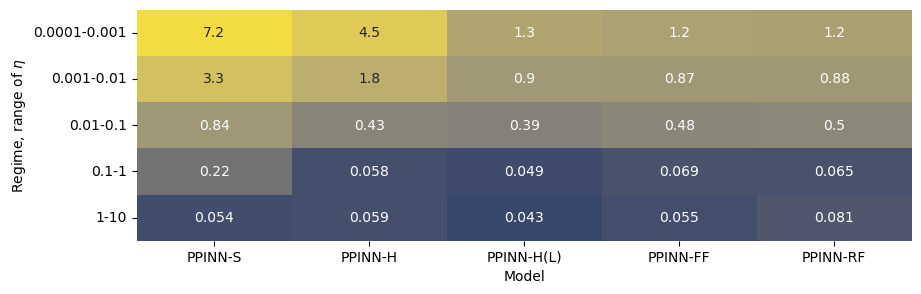

In [35]:
summary = []
summary.append(ps_l2_df[45000].tolist())
summary.append(ph_l2_df[45000].tolist())
summary.append(phl_l2_df[45000].tolist())
summary.append(psf_l2_df[45000].tolist())
summary.append(prf_l2_df[45000].tolist())
sum_df = pd.DataFrame(np.array(summary).T, columns=['PPINN-S', 'PPINN-H', 'PPINN-H(L)', 'PPINN-FF', 'PPINN-RF'], index=ps_l2_df.index)

f, ax = plt.subplots(1, 1, figsize=(10, 3), sharex=True)
sns.heatmap(sum_df, annot=True, cmap='cividis', norm=colors.LogNorm(vmin=0.01, vmax=10), ax=ax, cbar=False)
ax.set_xlabel('Model')
ax.set_ylabel('Regime, range of $\eta$')
plt.savefig('./figures/p_l2_errors_all.png', bbox_inches='tight', dpi=200)

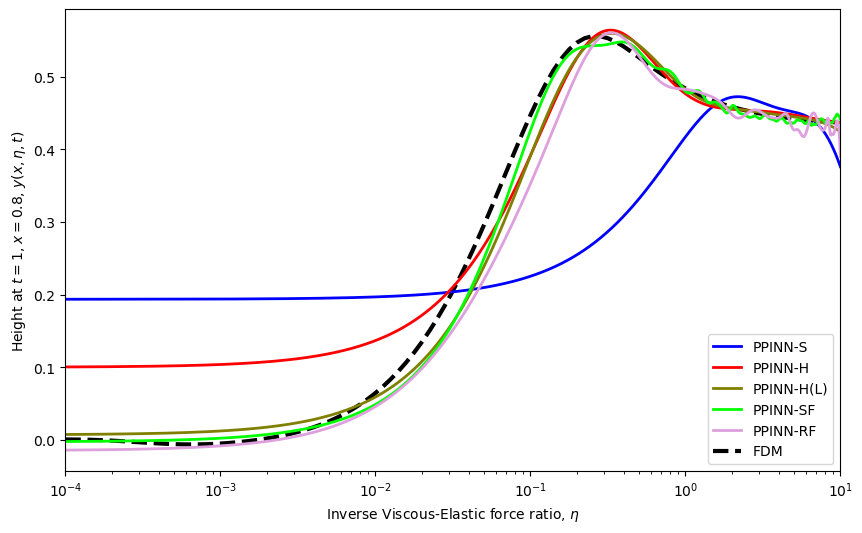

In [36]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
t = 1.001001001001001
x = 0.7989949748743719
etas = 1000
etas_all = np.exp(np.linspace(np.log(0.0001), np.log(10), etas))
X_flat = np.full_like(etas_all, x)
T_flat = np.full_like(etas_all, t)
inputs = np.stack([X_flat, etas_all, T_flat], axis=-1)
model_psoft.restore(save_path = f"./run_soft_0/model-45000.pt")
sol_flat = model_psoft.predict(inputs)
ax.plot(etas_all, sol_flat, label='PPINN-S', color='blue', lw=2)

model_phard.restore(save_path = f"./run_hard_0/model-45000.pt")
sol_flat = model_phard.predict(inputs)
ax.plot(etas_all, sol_flat, label='PPINN-H', color='red', lw=2)
model_phl.restore(save_path = f"./run_hard_log_0/model-45000.pt")
sol_flat = model_phl.predict(inputs)
ax.plot(etas_all, sol_flat, label='PPINN-H(L)', color='olive', lw=2)
model_psf.restore(save_path = f"./run_sf_0/model-45000.pt")
sol_flat = model_psf.predict(inputs)
ax.plot(etas_all, sol_flat, label='PPINN-SF', color='lime', lw=2)
model_prf.restore(save_path = f"./run_rf_0/model-45000.pt")
sol_flat = model_prf.predict(inputs)
ax.plot(etas_all, sol_flat, label='PPINN-RF', color='plum', lw=2)

etas = np.exp(np.linspace(np.log(0.0001), np.log(10), 101)).round(5)

y = []
for k, eta in enumerate(etas):
    df = pd.read_parquet(fr'./data/eta_{eta}.parquet')
    data_fd = df.pivot(index='t', columns='x', values='y')

    y.append(data_fd.values[100, 159])
ax.plot(etas, y, label='FDM', color='black', ls='dashed', lw=3, zorder=-1)
ax.set_xscale('log')
ax.set_xlim(0.0001, 10)
ax.set_xlabel('Inverse Viscous-Elastic force ratio, $\eta$')
ax.set_ylabel('Height at $t=1$, $x=0.8$, $y(x, \eta, t)$')
ax.legend(loc='lower right')
plt.savefig('./figures/eta_map_p.png', bbox_inches='tight', dpi=200)

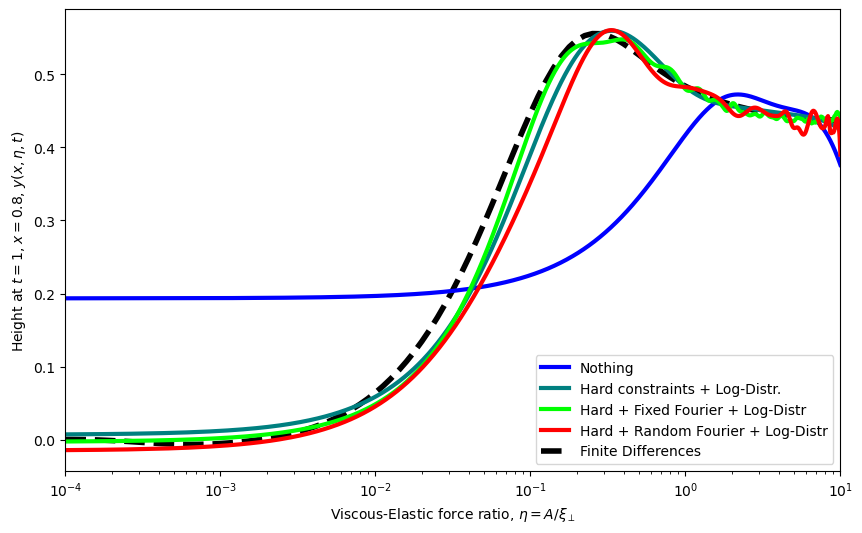

In [37]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
t = 1.001001001001001
x = 0.7989949748743719
etas = 1000
etas_all = np.exp(np.linspace(np.log(0.0001), np.log(10), etas))
X_flat = np.full_like(etas_all, x)
T_flat = np.full_like(etas_all, t)
inputs = np.stack([X_flat, etas_all, T_flat], axis=-1)
model_psoft.restore(save_path = f"./run_soft_0/model-45000.pt")
sol_flat = model_psoft.predict(inputs)
ax.plot(etas_all, sol_flat, label='Nothing', color='blue', lw=3)

model_phard.restore(save_path = f"./run_hard_0/model-45000.pt")
sol_flat = model_phard.predict(inputs)
#ax.plot(etas_all, sol_flat, label='PPINN-H', color='red', lw=2)
model_phl.restore(save_path = f"./run_hard_log_0/model-45000.pt")
sol_flat = model_phl.predict(inputs)
ax.plot(etas_all, sol_flat, label='Hard constraints + Log-Distr.', color='teal', lw=3)
model_psf.restore(save_path = f"./run_sf_0/model-45000.pt")
sol_flat = model_psf.predict(inputs)
ax.plot(etas_all, sol_flat, label='Hard + Fixed Fourier + Log-Distr', color='lime', lw=3)
model_prf.restore(save_path = f"./run_rf_0/model-45000.pt")
sol_flat = model_prf.predict(inputs)
ax.plot(etas_all, sol_flat, label='Hard + Random Fourier + Log-Distr', color='red', lw=3)

etas = np.exp(np.linspace(np.log(0.0001), np.log(10), 101)).round(5)

y = []
for k, eta in enumerate(etas):
    df = pd.read_parquet(fr'./data/eta_{eta}.parquet')
    data_fd = df.pivot(index='t', columns='x', values='y')

    y.append(data_fd.values[100, 159])
ax.plot(etas, y, label='Finite Differences', color='black', ls='dashed', lw=4, zorder=-1)
ax.set_xscale('log')
ax.set_xlim(0.0001, 10)
ax.set_xlabel(r'Viscous-Elastic force ratio, $\eta=A/\xi_\perp$')
ax.set_ylabel(r'Height at $t=1$, $x=0.8$, $y(x, \eta, t)$')
ax.legend(loc='lower right')
plt.savefig('./figures/eta_map_pres.pdf', bbox_inches='tight', dpi=200)

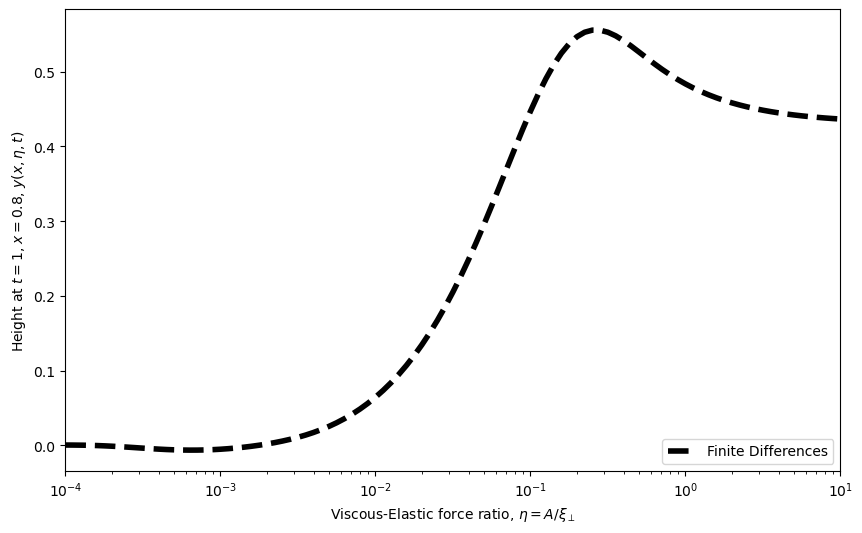

In [46]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
t = 1.001001001001001
x = 0.7989949748743719
etas = 1000
etas_all = np.exp(np.linspace(np.log(0.0001), np.log(10), etas))
X_flat = np.full_like(etas_all, x)
T_flat = np.full_like(etas_all, t)
inputs = np.stack([X_flat, etas_all, T_flat], axis=-1)
model_psoft.restore(save_path = f"./run_soft_0/model-45000.pt")
sol_flat = model_psoft.predict(inputs)
#ax.plot(etas_all, sol_flat, label='Nothing', color='blue', lw=3)

model_phard.restore(save_path = f"./run_hard_0/model-45000.pt")
sol_flat = model_phard.predict(inputs)
#ax.plot(etas_all, sol_flat, label='PPINN-H', color='red', lw=2)
model_phl.restore(save_path = f"./run_hard_log_0/model-45000.pt")
sol_flat = model_phl.predict(inputs)
#ax.plot(etas_all, sol_flat, label='Hard constraints + Log-Distr.', color='teal', lw=3)
model_psf.restore(save_path = f"./run_sf_0/model-45000.pt")
sol_flat = model_psf.predict(inputs)
#ax.plot(etas_all, sol_flat, label='Hard + Fixed Fourier + Log-Distr', color='lime', lw=3)
model_prf.restore(save_path = f"./run_rf_0/model-45000.pt")
sol_flat = model_prf.predict(inputs)
#ax.plot(etas_all, sol_flat, label='Hard + Random Fourier + Log-Distr', color='red', lw=3)

etas = np.exp(np.linspace(np.log(0.0001), np.log(10), 101)).round(5)

y = []
for k, eta in enumerate(etas):
    df = pd.read_parquet(fr'./data/eta_{eta}.parquet')
    data_fd = df.pivot(index='t', columns='x', values='y')

    y.append(data_fd.values[100, 159])
ax.plot(etas, y, label='Finite Differences', color='black', ls='dashed', lw=4, zorder=-1)
ax.set_xscale('log')
ax.set_xlim(0.0001, 10)
ax.set_xlabel(r'Viscous-Elastic force ratio, $\eta=A/\xi_\perp$')
ax.set_ylabel(r'Height at $t=1$, $x=0.8$, $y(x, \eta, t)$')
ax.legend(loc='lower right')
plt.savefig('./figures/eta_map_pres_2.pdf', bbox_inches='tight', dpi=200)

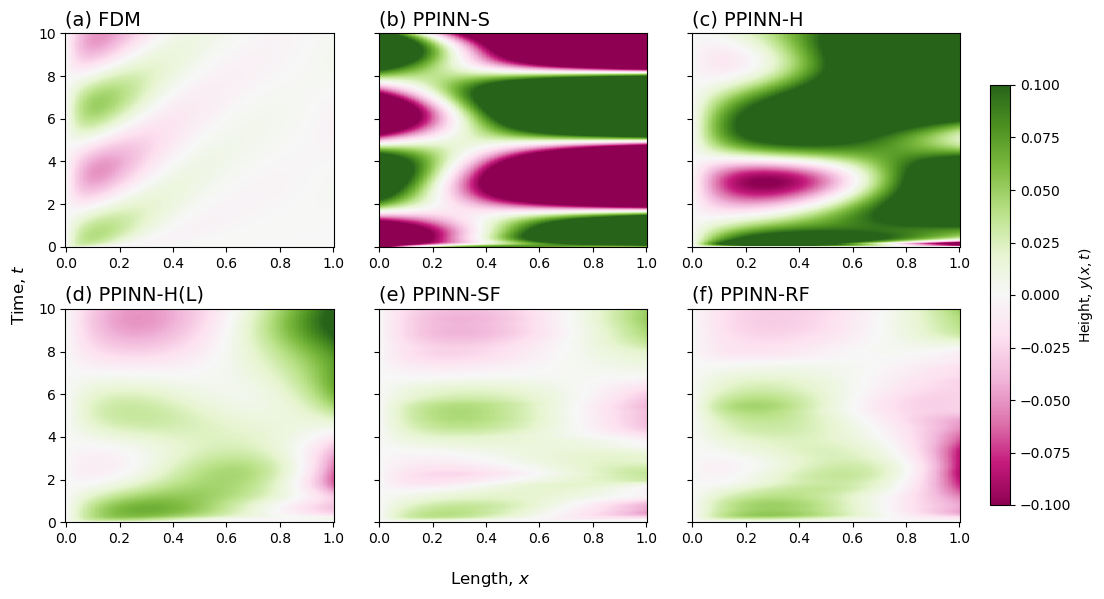

In [38]:
x, y = load_data(fr'./data/eta_long_{0.0001}.parquet')
eta = 0.0001
model_phard.restore(save_path = f"./run_hard_0/model-45000.pt")
ts = 1000
xs = 200

t_all = np.linspace(0, 10, ts)
x_all = np.linspace(0, 1, xs)
T, X = np.meshgrid(t_all, x_all, indexing='ij')
T_flat = T.ravel()
X_flat = X.ravel()
ETA_flat = np.full_like(T_flat, eta)
inputs = np.stack([X_flat, ETA_flat, T_flat], axis=-1)
sol_flat = model_phard.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_hard = pd.DataFrame(sol, columns=x_all, index=t_all)

model_psoft.restore(save_path = f"./run_soft_0/model-45000.pt")
sol_flat = model_psoft.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_soft = pd.DataFrame(sol, columns=x_all, index=t_all)

model_phl.restore(save_path = f"./run_hard_log_0/model-45000.pt")
sol_flat = model_phl.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_hl = pd.DataFrame(sol, columns=x_all, index=t_all)

model_psf.restore(save_path = f"./run_sf_0/model-45000.pt")
sol_flat = model_psf.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_sf = pd.DataFrame(sol, columns=x_all, index=t_all)

model_prf.restore(save_path = f"./run_rf_0/model-45000.pt")
sol_flat = model_prf.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_rf = pd.DataFrame(sol, columns=x_all, index=t_all)

f, ax = plt.subplots(2, 3, figsize=(10,6), sharey=True)

im = ax[0, 0].pcolormesh(X, T, y.reshape(1000, 200), cmap='PiYG', vmin=-0.1, vmax=0.1)
ax[0, 0].set_ylim(0, 10)
im = ax[0, 1].pcolormesh(X, T, data_soft.values, cmap='PiYG', vmin=-0.1, vmax=0.1)
im = ax[0, 2].pcolormesh(X, T, data_hard.values, cmap='PiYG', vmin=-0.1, vmax=0.1)
im = ax[1, 0].pcolormesh(X, T, data_hl.values, cmap='PiYG', vmin=-0.1, vmax=0.1)
im = ax[1, 1].pcolormesh(X, T, data_sf.values, cmap='PiYG', vmin=-0.1, vmax=0.1)
im = ax[1, 2].pcolormesh(X, T, data_rf.values, cmap='PiYG', vmin=-0.1, vmax=0.1)
ax[0, 0].set_title('(a) FDM', loc='left', fontsize=14,)
ax[0, 1].set_title('(b) PPINN-S', loc='left', fontsize=14,)
ax[0, 2].set_title('(c) PPINN-H', loc='left', fontsize=14)
ax[1, 0].set_title('(d) PPINN-H(L)', loc='left', fontsize=14)
ax[1, 1].set_title('(e) PPINN-SF', loc='left', fontsize=14)
ax[1, 2].set_title('(f) PPINN-RF', loc='left', fontsize=14)
f.supxlabel('Length, $x$')
f.supylabel('Time, $t$')

f.tight_layout()
cbar_ax = f.add_axes([1.0, 0.15, 0.02, 0.7])
f.colorbar(im, label='Height, $y(x, t)$', cax=cbar_ax)
plt.savefig('./figures/p_low.png', bbox_inches='tight', dpi=200)

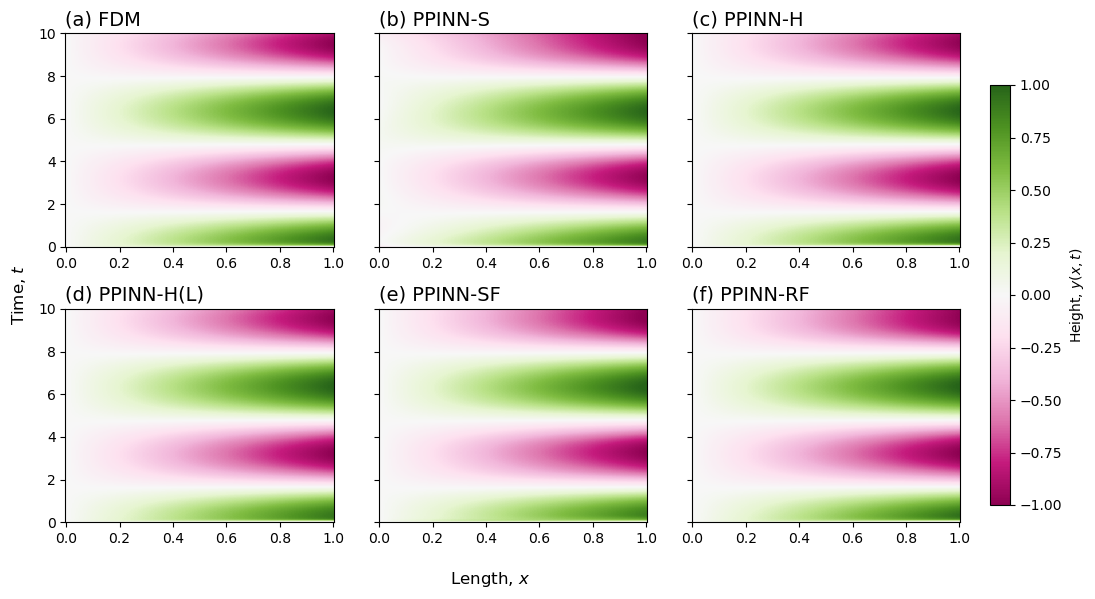

In [39]:
x, y = load_data(fr'./data/eta_long_{1}.parquet')
eta = 1
model_phard.restore(save_path = f"./run_hard_0/model-45000.pt")
ts = 1000
xs = 200

t_all = np.linspace(0, 10, ts)
x_all = np.linspace(0, 1, xs)
T, X = np.meshgrid(t_all, x_all, indexing='ij')
T_flat = T.ravel()
X_flat = X.ravel()
ETA_flat = np.full_like(T_flat, eta)
inputs = np.stack([X_flat, ETA_flat, T_flat], axis=-1)
sol_flat = model_phard.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_hard = pd.DataFrame(sol, columns=x_all, index=t_all)

model_psoft.restore(save_path = f"./run_soft_0/model-45000.pt")
sol_flat = model_psoft.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_soft = pd.DataFrame(sol, columns=x_all, index=t_all)

model_phl.restore(save_path = f"./run_hard_log_0/model-45000.pt")
sol_flat = model_phl.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_hl = pd.DataFrame(sol, columns=x_all, index=t_all)

model_psf.restore(save_path = f"./run_sf_0/model-45000.pt")
sol_flat = model_psf.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_sf = pd.DataFrame(sol, columns=x_all, index=t_all)

model_prf.restore(save_path = f"./run_rf_0/model-45000.pt")
sol_flat = model_prf.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_rf = pd.DataFrame(sol, columns=x_all, index=t_all)

f, ax = plt.subplots(2, 3, figsize=(10,6), sharey=True)

im = ax[0, 0].pcolormesh(X, T, y.reshape(1000, 200), cmap='PiYG', vmin=-1, vmax=1)
ax[0, 0].set_ylim(0, 10)
im = ax[0, 1].pcolormesh(X, T, data_soft.values, cmap='PiYG', vmin=-1, vmax=1)
im = ax[0, 2].pcolormesh(X, T, data_hard.values, cmap='PiYG', vmin=-1, vmax=1)
im = ax[1, 0].pcolormesh(X, T, data_hl.values, cmap='PiYG', vmin=-1, vmax=1)
im = ax[1, 1].pcolormesh(X, T, data_sf.values, cmap='PiYG', vmin=-1, vmax=1)
im = ax[1, 2].pcolormesh(X, T, data_rf.values, cmap='PiYG', vmin=-1, vmax=1)
ax[0, 0].set_title('(a) FDM', loc='left', fontsize=14,)
ax[0, 1].set_title('(b) PPINN-S', loc='left', fontsize=14,)
ax[0, 2].set_title('(c) PPINN-H', loc='left', fontsize=14)
ax[1, 0].set_title('(d) PPINN-H(L)', loc='left', fontsize=14)
ax[1, 1].set_title('(e) PPINN-SF', loc='left', fontsize=14)
ax[1, 2].set_title('(f) PPINN-RF', loc='left', fontsize=14)
f.supxlabel('Length, $x$')
f.supylabel('Time, $t$')

f.tight_layout()
cbar_ax = f.add_axes([1.0, 0.15, 0.02, 0.7])
f.colorbar(im, label='Height, $y(x, t)$', cax=cbar_ax)
plt.savefig('./figures/p_high.png', bbox_inches='tight', dpi=200)

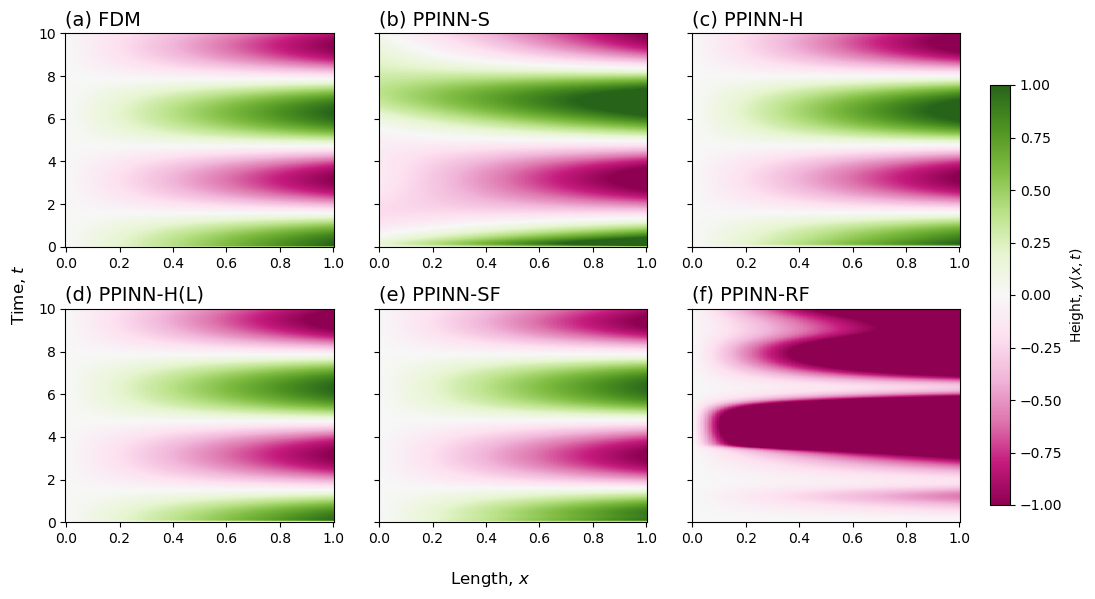

In [40]:
x, y = load_data(fr'./data/eta_long_{15}.parquet')
eta = 15
model_phard.restore(save_path = f"./run_hard_0/model-45000.pt")
ts = 1000
xs = 200

t_all = np.linspace(0, 10, ts)
x_all = np.linspace(0, 1, xs)
T, X = np.meshgrid(t_all, x_all, indexing='ij')
T_flat = T.ravel()
X_flat = X.ravel()
ETA_flat = np.full_like(T_flat, eta)
inputs = np.stack([X_flat, ETA_flat, T_flat], axis=-1)
sol_flat = model_phard.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_hard = pd.DataFrame(sol, columns=x_all, index=t_all)

model_psoft.restore(save_path = f"./run_soft_0/model-45000.pt")
sol_flat = model_psoft.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_soft = pd.DataFrame(sol, columns=x_all, index=t_all)

model_phl.restore(save_path = f"./run_hard_log_0/model-45000.pt")
sol_flat = model_phl.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_hl = pd.DataFrame(sol, columns=x_all, index=t_all)

model_psf.restore(save_path = f"./run_sf_0/model-45000.pt")
sol_flat = model_psf.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_sf = pd.DataFrame(sol, columns=x_all, index=t_all)

model_prf.restore(save_path = f"./run_rf_0/model-45000.pt")
sol_flat = model_prf.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data_rf = pd.DataFrame(sol, columns=x_all, index=t_all)

f, ax = plt.subplots(2, 3, figsize=(10,6), sharey=True)

im = ax[0, 0].pcolormesh(X, T, y.reshape(1000, 200), cmap='PiYG', vmin=-1, vmax=1)
ax[0, 0].set_ylim(0, 10)
im = ax[0, 1].pcolormesh(X, T, data_soft.values, cmap='PiYG', vmin=-1, vmax=1)
im = ax[0, 2].pcolormesh(X, T, data_hard.values, cmap='PiYG', vmin=-1, vmax=1)
im = ax[1, 0].pcolormesh(X, T, data_hl.values, cmap='PiYG', vmin=-1, vmax=1)
im = ax[1, 1].pcolormesh(X, T, data_sf.values, cmap='PiYG', vmin=-1, vmax=1)
im = ax[1, 2].pcolormesh(X, T, data_rf.values, cmap='PiYG', vmin=-1, vmax=1)
ax[0, 0].set_title('(a) FDM', loc='left', fontsize=14,)
ax[0, 1].set_title('(b) PPINN-S', loc='left', fontsize=14,)
ax[0, 2].set_title('(c) PPINN-H', loc='left', fontsize=14)
ax[1, 0].set_title('(d) PPINN-H(L)', loc='left', fontsize=14)
ax[1, 1].set_title('(e) PPINN-SF', loc='left', fontsize=14)
ax[1, 2].set_title('(f) PPINN-RF', loc='left', fontsize=14)
f.supxlabel('Length, $x$')
f.supylabel('Time, $t$')

f.tight_layout()
cbar_ax = f.add_axes([1.0, 0.15, 0.02, 0.7])
f.colorbar(im, label='Height, $y(x, t)$', cax=cbar_ax)
plt.savefig('./figures/p_15.png', bbox_inches='tight', dpi=200)

Compiling model...
'compile' took 0.000153 s



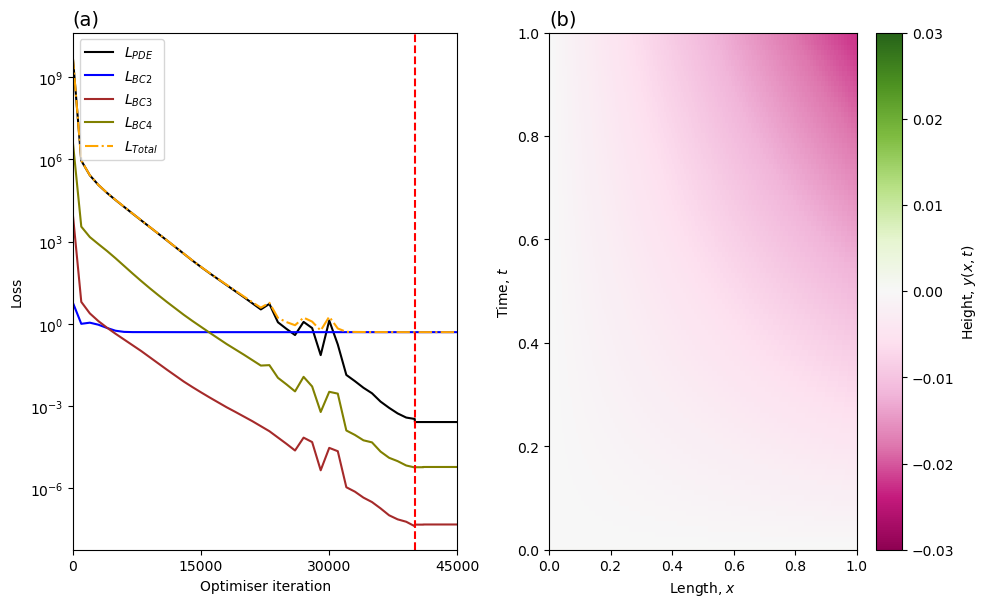

In [41]:
net_sf = dde.nn.FNN([22] + [20] * 4 + [1], "tanh", "Glorot uniform")
def feature_transform_sfourier(x):
    features = torch.cat([x,
                         torch.sin(np.pi*x), torch.cos(np.pi*x),
                         torch.sin(2*np.pi*x), torch.cos(2*np.pi*x),
                         torch.sin(3*np.pi*x), torch.cos(3*np.pi*x),
                         torch.sin(4*np.pi*x), torch.cos(4*np.pi*x),
                         torch.sin(5*np.pi*x), torch.cos(5*np.pi*x),], dim=1)
    return features

def output_transform(x, y):
    return x[:, 0:1]*x[:, 1:2]*y

net_sf.apply_feature_transform(feature_transform_sfourier)
net_sf.apply_output_transform(output_transform)
model_sf = dde.Model(data, net_sf)
model_sf.compile('L-BFGS')
loss = np.loadtxt('./fixed_hardbcs_sf_1_withx/loss.dat')
loss_df = pd.DataFrame(loss, columns=['step', 'train_pde', 'train_bc2', 'train_bc3', 'train_bc4',
                           'test_pde', 'test_bc2', 'test_bc3', 'test_bc4',]) # [bc1, bc2, bc3, bc4, ic]
loss_df['train_loss'] = loss_df['train_pde'] +\
loss_df['train_bc2'] + loss_df['train_bc3'] + loss_df['train_bc4']
model_sf.restore(save_path = "./fixed_hardbcs_sf_1_withx/model-45000.pt")
ts = 1000
xs = 200

t_all = np.linspace(0, 10, ts)
x_all = np.linspace(0, 1, xs)
T, X = np.meshgrid(t_all, x_all, indexing='ij')
T_flat = T.ravel()
X_flat = X.ravel()

inputs = np.stack([X_flat, T_flat], axis=-1)
sol_flat = model_sf.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data = pd.DataFrame(sol, columns=x_all, index=t_all)

x_val = data.columns.values
t_val = data.index.values
X, T = np.meshgrid(x_val, t_val)

f, ax = plt.subplots(1, 2, figsize=(10, 6))
im = ax[1].pcolormesh(X, T, data.values, cmap='PiYG', vmin=-0.03, vmax=0.03)
ax[1].set_xlabel('Length, $x$')
ax[1].set_ylabel('Time, $t$')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[0].plot(loss_df['step'], loss_df['train_pde'], label='$L_{PDE}$', color='black')
ax[0].plot(loss_df['step'], loss_df['train_bc2'], label='$L_{BC2}$', color='blue')
ax[0].plot(loss_df['step'], loss_df['train_bc3'], label='$L_{BC3}$', color='brown')
ax[0].plot(loss_df['step'], loss_df['train_bc4'], label='$L_{BC4}$', color='olive')
ax[0].plot(loss_df['step'], loss_df['train_loss'], label='$L_{Total}$', ls='dashdot', color='orange')
ax[0].set_xlabel('Optimiser iteration')
ax[0].set_ylabel('Loss')
ax[0].axvline(40000, ls='dashed', color='red')
ax[0].set_xlim(0, 45000)
ax[0].set_xticks([0, 15000, 30000, 45000])
ax[0].set_yscale('log')
ax[0].legend(loc='upper left')
f.colorbar(im, label='Height, $y(x, t)$')
f.tight_layout()
ax[0].set_title('(a)', loc='left', fontsize=14,)
ax[1].set_title('(b)', loc='left', fontsize=14,)
plt.savefig('./figures/single_sf_withx.png', bbox_inches='tight', dpi=200)

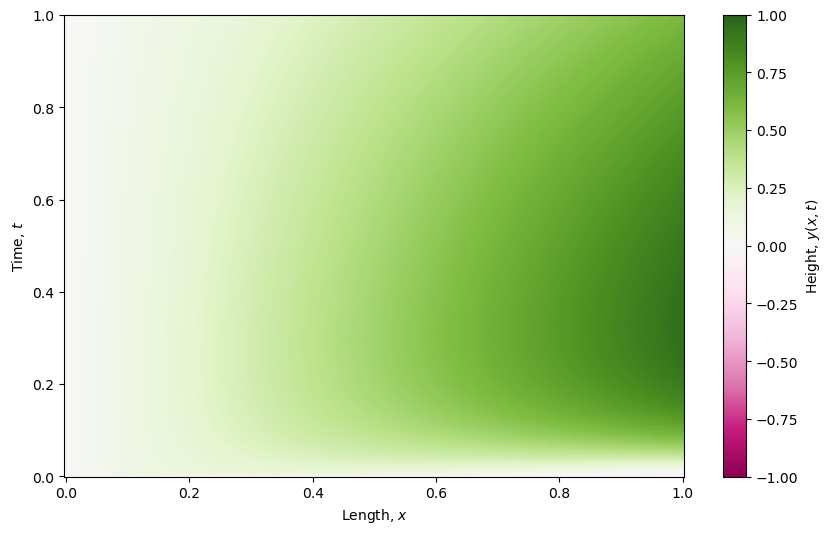

In [42]:
df = pd.read_parquet('./data/eta_1.parquet')
data = df.pivot(index='t', columns='x', values='y')

x_val = data.columns.values
t_val = data.index.values
X, T = np.meshgrid(x_val, t_val)
f, ax = plt.subplots(1, 1, figsize=(10, 6))
im =ax.pcolormesh(X, T, data.values, cmap='PiYG', vmin=-1, vmax=1)
ax.set_xlabel('Length, $x$')
ax.set_ylabel('Time, $t$')
f.colorbar(im, label='Height, $y(x, t)$')
plt.savefig('./figures/eta_1-1_analytical.png', bbox_inches='tight', dpi=200)

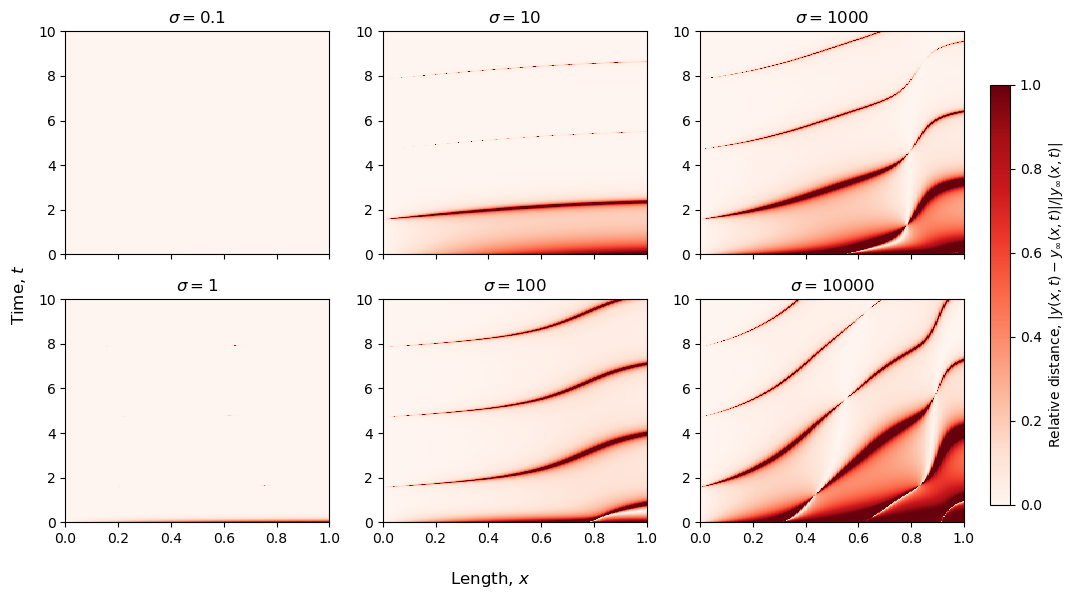

In [43]:
f, ax = plt.subplots(2, 3, sharex=True, figsize=(10, 6))
df01 = pd.read_parquet('./data/s0.1.parquet')
df1 = pd.read_parquet('./data/s1.0.parquet')
df10 = pd.read_parquet('./data/s10.0.parquet')
df100 = pd.read_parquet('./data/s100.0.parquet')
df1000 = pd.read_parquet('./data/s1000.0.parquet')
df10000 = pd.read_parquet('./data/s10000.0.parquet')
colours = ['blue', 'red', 'olive', 'black', 'purple']
data = df01.pivot(index='t', columns='x', values='y')
x_val = data.columns.values
t_val = data.index.values
X, T = np.meshgrid(x_val, t_val)
l0 = (1/0.1)**(1/4)
sol = np.real(analytical_y(1, l0, 1, 1, X.ravel(), T.ravel())).reshape(1000, 200)
im = ax[0, 0].pcolormesh(X, T, np.abs(data.values-sol)/(0.00001+np.abs(sol)), cmap='Reds', vmin=0, vmax=1)
ax[0, 0].set_xlim(0, 1)
ax[0, 0].set_ylim(0, 10)

data = df1.pivot(index='t', columns='x', values='y')
x_val = data.columns.values
t_val = data.index.values
X, T = np.meshgrid(x_val, t_val)
l0 = (1/1)**(1/4)
sol = np.real(analytical_y(1, l0, 1, 1, X.ravel(), T.ravel())).reshape(1000, 200)
im = ax[1, 0].pcolormesh(X, T, np.abs(data.values-sol)/(0.00001+np.abs(sol)), cmap='Reds', vmin=0, vmax=1)
ax[0, 1].set_xlim(0, 1)
ax[0, 1].set_ylim(0, 10)

data = df10.pivot(index='t', columns='x', values='y')
x_val = data.columns.values
t_val = data.index.values
X, T = np.meshgrid(x_val, t_val)
l0 = (1/10)**(1/4)
sol = np.real(analytical_y(1, l0, 1, 1, X.ravel(), T.ravel())).reshape(1000, 200)
im = ax[0, 1].pcolormesh(X, T, np.abs(data.values-sol)/(0.00001+np.abs(sol)), cmap='Reds', vmin=0, vmax=1)
ax[0, 2].set_xlim(0, 1)
ax[0, 2].set_ylim(0, 10)

data = df100.pivot(index='t', columns='x', values='y')
x_val = data.columns.values
t_val = data.index.values
X, T = np.meshgrid(x_val, t_val)
l0 = (1/100)**(1/4)
sol = np.real(analytical_y(1, l0, 1, 1, X.ravel(), T.ravel())).reshape(1000, 200)
im = ax[1, 1].pcolormesh(X, T, np.abs(data.values-sol)/(0.00001+np.abs(sol)), cmap='Reds', vmin=0, vmax=1)
ax[1, 0].set_xlim(0, 1)
ax[1, 0].set_ylim(0, 10)

data = df1000.pivot(index='t', columns='x', values='y')
x_val = data.columns.values
t_val = data.index.values
X, T = np.meshgrid(x_val, t_val)
l0 = (1/1000)**(1/4)
sol = np.real(analytical_y(1, l0, 1, 1, X.ravel(), T.ravel())).reshape(1000, 200)
im = ax[0, 2].pcolormesh(X, T, np.abs(data.values-sol)/(0.00001+np.abs(sol)), cmap='Reds', vmin=0, vmax=1)
ax[1, 1].set_xlim(0, 1)
ax[1, 1].set_ylim(0, 10)

data = df10000.pivot(index='t', columns='x', values='y')
x_val = data.columns.values
t_val = data.index.values
X, T = np.meshgrid(x_val, t_val)
l0 = (1/10000)**(1/4)
sol = np.real(analytical_y(1, l0, 1, 1, X.ravel(), T.ravel())).reshape(1000, 200)
im = ax[1, 2].pcolormesh(X, T, np.abs(data.values-sol)/(0.00001+np.abs(sol)), cmap='Reds', vmin=0, vmax=1)
ax[1, 2].set_xlim(0, 1)
ax[1, 2].set_ylim(0, 10)
ax[0, 0].set_title(r'$\sigma = 0.1$')
ax[1, 0].set_title(r'$\sigma = 1$')
ax[0, 1].set_title(r'$\sigma = 10$')
ax[1, 1].set_title(r'$\sigma = 100$')
ax[0, 2].set_title(r'$\sigma = 1000$')
ax[1, 2].set_title(r'$\sigma = 10000$')
f.supxlabel('Length, $x$')
f.supylabel('Time, $t$')
f.tight_layout()
cbar_ax = f.add_axes([1.0, 0.15, 0.02, 0.7])
f.colorbar(im, label='Relative distance, $|y(x,t)-y_\infty(x,t)|/|y_\infty(x,t)|$', cax=cbar_ax)
plt.savefig('./figures/steady-state.png', bbox_inches='tight', dpi=200)

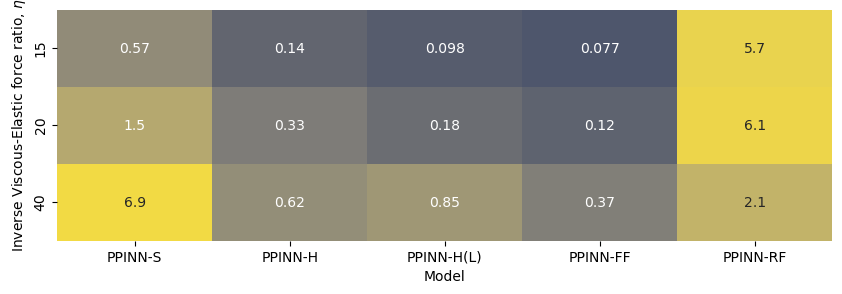

In [44]:
l2_re = np.zeros((3, 5))
etas = [15, 20, 40]
model_psoft.restore(save_path = f"./run_soft_0/model-45000.pt")
model_phard.restore(save_path = f"./run_hard_0/model-45000.pt")
model_phl.restore(save_path = f"./run_hard_log_0/model-45000.pt")
model_psf.restore(save_path = f"./run_sf_0/model-45000.pt")
model_prf.restore(save_path = f"./run_rf_0/model-45000.pt")
for k, eta in enumerate(etas):
    x, y = load_data(fr'./data/eta_long_{eta}.parquet')
    l2_re[k, 0] = dde.metrics.l2_relative_error(y, model_psoft.predict(x))
    l2_re[k, 1] = dde.metrics.l2_relative_error(y, model_phard.predict(x))
    l2_re[k, 2] = dde.metrics.l2_relative_error(y, model_phl.predict(x))
    l2_re[k, 3] = dde.metrics.l2_relative_error(y, model_psf.predict(x))
    l2_re[k, 4] = dde.metrics.l2_relative_error(y, model_prf.predict(x))

l2re_df = pd.DataFrame(l2_re, index=etas, columns=['PPINN-S', 'PPINN-H', 'PPINN-H(L)', 'PPINN-FF', 'PPINN-RF'])
f, ax = plt.subplots(1, 1, figsize=(10, 3), sharex=True)
sns.heatmap(l2re_df, annot=True, cmap='cividis', norm=colors.LogNorm(vmin=0.01, vmax=10), ax=ax, cbar=False)
ax.set_xlabel('Model')
ax.set_ylabel('Inverse Viscous-Elastic force ratio, $\eta$')
plt.savefig('./figures/p_l2_errors_extrapolation_high.png', bbox_inches='tight', dpi=200)

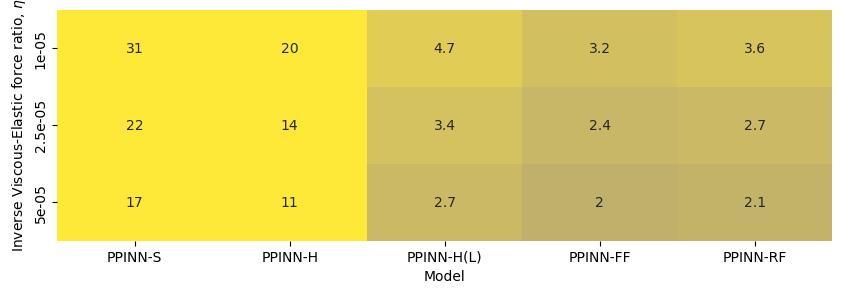

In [45]:
l2_re = np.zeros((3, 5))
etas = [0.00001, 0.000025, 0.00005]
model_psoft.restore(save_path = f"./run_soft_0/model-45000.pt")
model_phard.restore(save_path = f"./run_hard_0/model-45000.pt")
model_phl.restore(save_path = f"./run_hard_log_0/model-45000.pt")
model_psf.restore(save_path = f"./run_sf_0/model-45000.pt")
model_prf.restore(save_path = f"./run_rf_0/model-45000.pt")
for k, eta in enumerate(etas):
    x, y = load_data(fr'./data/eta_long_{eta}.parquet')
    l2_re[k, 0] = dde.metrics.l2_relative_error(y, model_psoft.predict(x))
    l2_re[k, 1] = dde.metrics.l2_relative_error(y, model_phard.predict(x))
    l2_re[k, 2] = dde.metrics.l2_relative_error(y, model_phl.predict(x))
    l2_re[k, 3] = dde.metrics.l2_relative_error(y, model_psf.predict(x))
    l2_re[k, 4] = dde.metrics.l2_relative_error(y, model_prf.predict(x))

l2re_df = pd.DataFrame(l2_re, index=etas, columns=['PPINN-S', 'PPINN-H', 'PPINN-H(L)', 'PPINN-FF', 'PPINN-RF'])
f, ax = plt.subplots(1, 1, figsize=(10, 3), sharex=True)
sns.heatmap(l2re_df, annot=True, cmap='cividis', norm=colors.LogNorm(vmin=0.01, vmax=10), ax=ax, cbar=False)
ax.set_xlabel('Model')
ax.set_ylabel('Inverse Viscous-Elastic force ratio, $\eta$')
plt.savefig('./figures/p_l2_errors_extrapolation_low.png', bbox_inches='tight', dpi=200)